# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import functools

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.spatial.distance import cdist
from pandas.util.testing import assert_frame_equal

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

g_random_state = np.random.RandomState(42)

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Load in the file for Data Dictionary for easiness
#import markdown
#from IPython.core.display import display, HTML
#f = open('Data_Dictionary.md', 'r')
#display(HTML(markdown.markdown(f.read())))

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Number of rows in the dataset:    {azdias.shape[0]}')
print(f'Number of columns in the dataset: {azdias.shape[1]}')

display(azdias.head())

Number of rows in the dataset:    891221
Number of columns in the dataset: 85


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
display(azdias.describe())

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [6]:
print('Check if we have the same column name more than once in the feature description file.')
print(np.where(pd.DataFrame(feat_info['attribute'].value_counts() > 1)))
print('\nColumn names are unique so we can set them as index for the feature description file.')

feat_info.set_index('attribute', inplace = True)
display(feat_info.head(3))

Check if we have the same column name more than once in the feature description file.
(array([], dtype=int64), array([], dtype=int64))

Column names are unique so we can set them as index for the feature description file.


information_level         type missing_or_unknown
attribute                                                             
AGER_TYP                        person  categorical             [-1,0]
ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
ANREDE_KZ                       person  categorical             [-1,0]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdiasConverted = azdias.copy()
for item in azdiasConverted.columns.values:
    if not feat_info.loc[item, 'missing_or_unknown'] == '[]':
        v_missing = functools.reduce(lambda a, b: a.replace(*b), 
                                                  [('[', ''), (']','')],
                                                  feat_info.loc[item, 'missing_or_unknown'] )          
        v_missing = { int(value) if np.issubdtype(azdiasConverted[item].dtype, np.number) else value: np.NaN 
                         for value in v_missing.split(',') }
        azdiasConverted[item] = azdiasConverted[item].replace(v_missing)
display(azdiasConverted.head())

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
def calculateNullCorr(p_df, p_column):
    v_data = p_df[(p_df[p_column].isnull())]
    
    v_df = pd.DataFrame()
    for item in v_data.columns.values:
        if item != p_column:
            v_values = pd.DataFrame({ 'Column Name': item, 
                                      'Values No':   v_data[item].value_counts(dropna = False) }).reset_index()
            v_values.columns = ['Values', 'Column Name', 'Values %']
            v_values = v_values[['Column Name', 'Values', 'Values %']]
            v_values['Values %'] = v_values['Values %'] / v_data.shape[0]
            v_df = v_df.append(v_values, ignore_index = True)    
    
    return v_df, v_df[v_df['Values %'] > 0.60].pivot("Column Name", "Values", "Values %")

def calculateNotNullCorr(p_df, p_column):
    v_data = p_df[~(p_df[p_column].isnull())]
    
    v_df = pd.DataFrame()
    for item in v_data.columns.values:
        if item != p_column:
            v_values = pd.DataFrame({ 'Column Name': item, 
                                      'Values No':   v_data[item].value_counts(dropna = False) }).reset_index()
            v_values.columns = ['Values', 'Column Name', 'Values %']
            v_values = v_values[['Column Name', 'Values', 'Values %']]
            v_values['Values %'] = v_values['Values %'] / v_data.shape[0]
            v_df = v_df.append(v_values, ignore_index = True)    
    
    return v_df, v_df[v_df['Values %'] > 0.60].pivot("Column Name", "Values", "Values %")

def getColumnFillValues(p_df):
    return p_df.apply(lambda x: -1 if np.issubdtype(x.dtype, np.number) else '-1')

def displayColumnCorrValues(p_df, p_fillValues, p_col_1, p_colLst_2): 
    def extendList(p_lst_01, p_lst_02):
        v_lst = p_lst_01.copy()
        v_lst.extend(p_lst_02)
        return v_lst
        
    v_colLst = extendList(p_colLst_2, [p_col_1])       
    v_df = p_df[v_colLst].copy().fillna(p_fillValues)
    v_df['Binary'] = v_df[p_col_1].apply(lambda x: -1 if int(x) == -1 else 0)   
    v_nullCount    = v_df[v_df['Binary'] == -1].index.size
    v_notNullCount = v_df[v_df['Binary'] == 0].index.size
    
    v_group = v_df.groupby(v_colLst).agg( { p_col_1: ['count'] } ).reset_index()    
    v_group.columns = extendList(p_colLst_2, [p_col_1, 'No'])
    v_group['Binary'] = v_group[p_col_1].apply(lambda x: -1 if int(x) == -1 else 0)
    
    v_null_index    = v_group[v_group['Binary'] == -1].index
    v_notNull_index = v_group[v_group['Binary'] == 0].index
    
    v_group.loc[v_null_index, 'No%']    = (v_group.loc[v_null_index, 'No'] / v_nullCount * 100).round(2)
    v_group.loc[v_notNull_index, 'No%'] = (v_group.loc[v_notNull_index, 'No'] / v_notNullCount * 100).round(2)
    
    v_colLst = extendList(p_colLst_2, ['Binary'])
    v_groupSum = v_group.groupby(v_colLst).agg({'No': ['sum']}).reset_index()    
    v_groupSum.columns = extendList(p_colLst_2, ['Binary', 'No_Sum'])
    
    v_colLst = extendList(p_colLst_2, ['Binary'])
    v_group = v_group.merge(v_groupSum, how = 'inner', on = v_colLst)
    
    v_group['Value'] = v_group[p_col_1].astype(str) \
                         + ' (' + ( v_group['No'] / v_group['No_Sum'] * 100).round(2).astype(str) + '%) '
    
    v_colLst = extendList(p_colLst_2, ['Binary'])
    v_group = ( v_group.groupby(v_colLst)
                       .agg( { 'No%': ['sum'],
                               'Value': [(lambda x: ';'.join(x))] } ).reset_index() )
    v_group.columns = extendList(p_colLst_2, ['Binary', 'No%', 'Value'])
    v_group['Value'] = v_group['Value'].apply(lambda x: x.split(';'))
    
    v_colLst = extendList(p_colLst_2, ['No%', 'Value'])
    v_df = v_group.loc[v_group[v_group['Binary'] == 0].index][v_colLst]
    v_df = v_df.merge( v_group.loc[v_group[v_group['Binary'] == -1].index][v_colLst], 
                       how = 'outer', 
                       on = p_colLst_2, 
                       suffixes=('_Not Null', '_Null') )
    
    display(v_df)    
    return

g_azdiasConverted_fillValues = getColumnFillValues(azdiasConverted)

In [9]:
def calculateNotNullValueCorr(p_df, p_fillValues, p_column, p_percent, p_values_no):
    v_data = p_df[~(p_df[p_column].isnull())].copy().fillna(p_fillValues)
    v_data['No'] = 1
    
    v_group = v_data.groupby(p_column).agg({'No': 'count'}).reset_index()
    v_group.columns = [p_column, 'No']
    v_group['No%'] = (v_group['No'] / v_data.shape[0] * 100).round(2)
            
    v_df = pd.DataFrame()
    v_data.drop('No', axis = 1, inplace = True)
    v_group.set_index(p_column, inplace = True)
    for colValues in list(v_group.index.values):        
        v_values = v_data.loc[v_data[v_data[p_column] == colValues].index]        
        for item in v_data.columns.values:
            if item != p_column:
                v_item = pd.DataFrame({ 'Column Name': item, 
                                        'Values No':   v_values[item].value_counts() }).reset_index()                
                v_item.columns = ['Values', 'Column Name', 'Values No']
                v_item[p_column] = colValues
                v_df = v_df.append(v_item, ignore_index = True)
    v_group.reset_index(inplace = True)
    
    v_df_g = v_df.groupby(['Column Name', 'Values']).agg({'Values No': ['sum']}).reset_index()
    v_df_g.columns = ['Column Name', 'Values', 'Values Sum']    
    v_df = v_df.merge(v_df_g, how = 'inner', on = ['Column Name', 'Values'])
    
    v_df_g = v_df.groupby(['Column Name']).agg({'Values No': ['sum']}).reset_index()
    v_df_g.columns = ['Column Name', 'Values Total']    
    v_df = v_df.merge(v_df_g, how = 'inner', on = ['Column Name'])
    
    v_group = v_group.merge(v_df, how = 'inner', on = p_column)
    v_group['Values %'] = (v_group['Values No'] / v_group['Values Sum'] * 100).round(2) 
    v_group = v_group[ (v_group['Values %'] > p_percent) 
                       & (v_group['Values No'] > p_values_no)
                       & (v_group['Values'] != '-1') ]
    v_group.sort_values('Values %', ascending = False, inplace = True)
    
    return v_group

We will perform an assessment of how much missing data there is in each column of the dataset in order to check if there are any outlier columns.

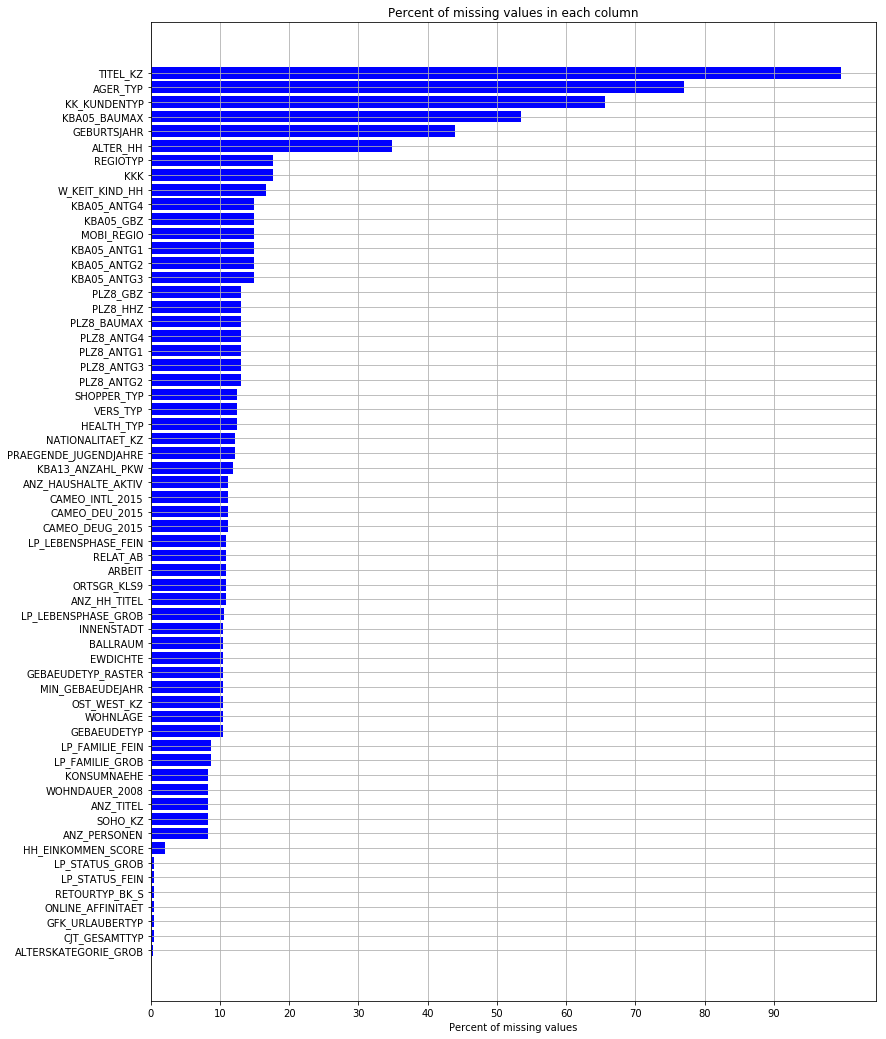

In [10]:
v_null = azdiasConverted.isnull().sum()
v_null = pd.DataFrame(v_null[v_null > 0].sort_values(ascending = True)).reset_index()
v_null.columns = ['Column Name', 'Missing %']
v_null['Missing %'] = v_null['Missing %'] / azdiasConverted.shape[0] * 100

fig, ax = plt.subplots(figsize=(13, 18))
rects = ax.barh(v_null.index.values, v_null['Missing %'], color='blue')
ax.set_yticks(v_null.index.values)
ax.set_xticks([idx for idx in range(0, 100, 10)])
ax.set_yticklabels(v_null['Column Name'], rotation='horizontal')
ax.set_xlabel("Percent of missing values")
ax.set_title("Percent of missing values in each column")
plt.grid(True)
plt.show()

For the missing values pattern we take into account that we can have the following situations:
   - **data is Missing Completely at Random (MCAR)** - no relationship between the missingness of the data and any values, observed or missing (nothing systematic going on)
   - **data is Missing at Random (MAR)** - we have a systematic relationship between the propensity of missing values and the observed data, but not the missing data. Whether an observation is missing has nothing to do with the missing values, but it does have to do with the values of an individual’s observed variables (eg: women are less-likely to tell their age or weight)
   - **data is Missing Not at Random (MNAR)** - there is a relationship between the propensity of a value to be missing and its values. This is a case where the people with the lowest education are missing on education.
   
Also we have to choose a threshold value for the outliers. Based on the visualization above, I will choose the threshold at **50%**.

#### Discussion 1.1.2.1: Assess Missing Data in Each Column (more than 50% of missing data)

In [11]:
g_nullThresholdLimit = 50
v_nullThreshold = ( v_null[v_null['Missing %'] >= g_nullThresholdLimit]
                           .sort_values('Missing %', ascending = False)
                           .reset_index(drop = True) )
display(v_nullThreshold)

Column Name  Missing %
0      TITEL_KZ  99.757636
1      AGER_TYP  76.955435
2  KK_KUNDENTYP  65.596749
3  KBA05_BAUMAX  53.468668

The columns for which we have missing values with a percent of more than 50% of the total number of rows are the following:
    - TITEL_KZ (99.76%)
    - AGER_TYP (76.96%)
    - KK_KUNDENTYP (65.60%)
    - KBA05_BAUMAX (53.47%)

In order to investigate the patterns in the amount of missing data in each of the above columns, I will create two types of correlation heatmap for every **"column_A"** which has missing values.

We will be using the heatmaps below (for every column and general one) in order to check if a column:
    - tends to be missing together with another column
    - tends to be missing for a particular value of a given column

In order to determine the correlation between a missing / not missing value in **"column_A"** and the value(s) in another column **"column_B"**, I have selected: 
   - only the rows where we have a NaN value for "column_A" and extracted the percentage of occurences for a particular value (NaN included) in "column_B"
   - only the rows where we don't have a NaN value for "column_A" and extracted the percentage of occurences for a particular value (NaN excluded) in "column_B"

The first type of heatmap contains the correlation columns that have more than 60% of the time a particular value (NaN included) for the rows where **"column_A"** is **missing**.

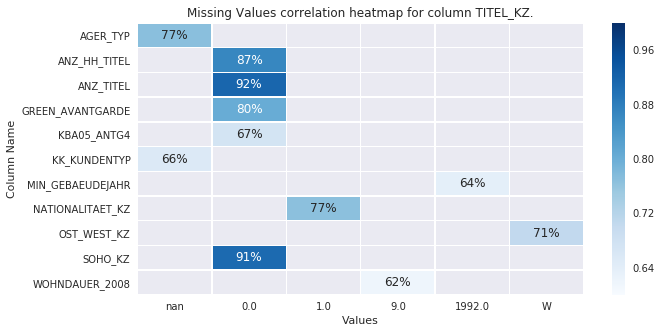

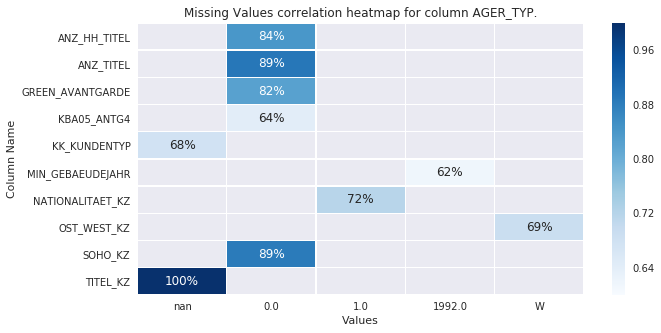

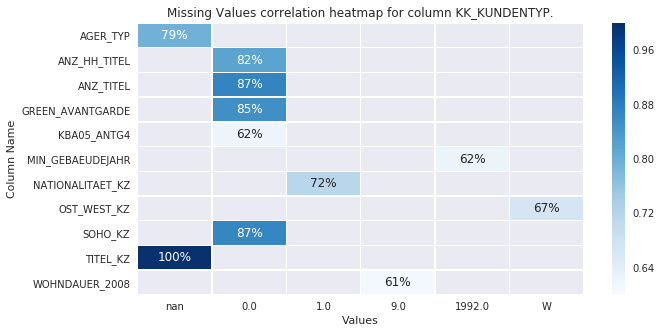

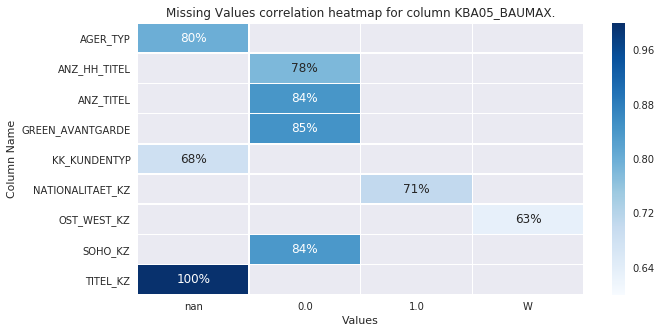

In [12]:
# Investigate patterns in the amount of missing data in each column when values are NaN.
sns.set()
v_df_all = pd.DataFrame()
for item in v_nullThreshold['Column Name'].values:
    v_item, v_item_60 = calculateNullCorr(azdiasConverted, item)  
    
    v_item['Base Column Name'] = item    
    v_df_all = v_df_all.append(v_item.reset_index(drop = True), ignore_index = True)   
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap( v_item_60, annot = True, fmt = ".0%", 
                 cmap = "Blues", vmin = 0.60, vmax = 1.00, linewidths=.5, ax = ax )
    ax.set_title(f'Missing Values correlation heatmap for column {item}.')
    plt.show()

The second type of heatmap contains the column level correlation heatmap for the columns that have more than 60% of the time a particular value (NaN included) for the rows where "column_A" is **not missing**.

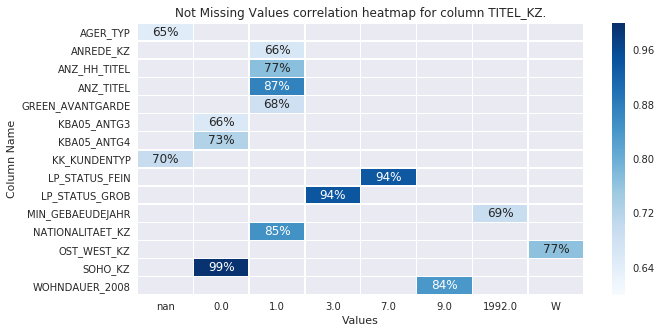

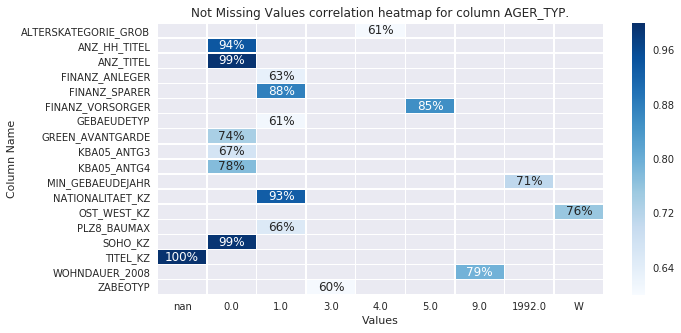

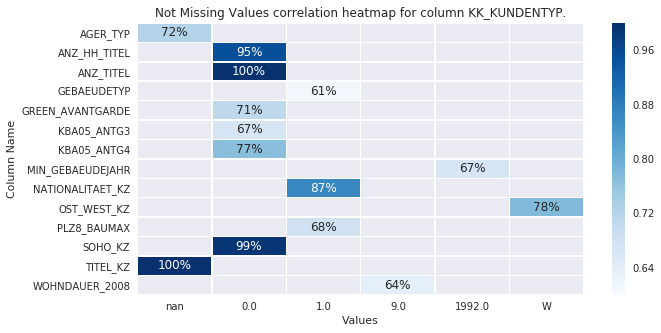

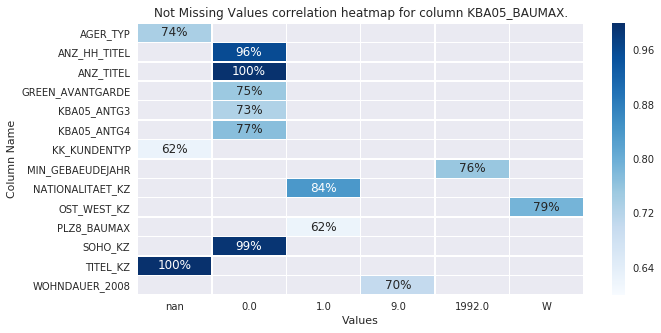

In [13]:
# Investigate patterns in the amount of missing data in each column when values are not NaN.
sns.set()
v_df_all = pd.DataFrame()
for item in v_nullThreshold['Column Name'].values:
    v_item, v_item_60 = calculateNotNullCorr(azdiasConverted, item)  
    
    v_item['Base Column Name'] = item    
    v_df_all = v_df_all.append(v_item.reset_index(drop = True), ignore_index = True)   
    
    f, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap( v_item_60, annot = True, fmt = ".0%", 
                 cmap = "Blues", vmin = 0.60, vmax = 1.00, linewidths=.5, ax = ax )
    ax.set_title(f'Not Missing Values correlation heatmap for column {item}.')
    plt.show()

The third type of heatmap contains the general level correlation heatmap for the columns that have more than 60% of the time a particular value (NaN included) for the rows where "column_A" is **not missing**.

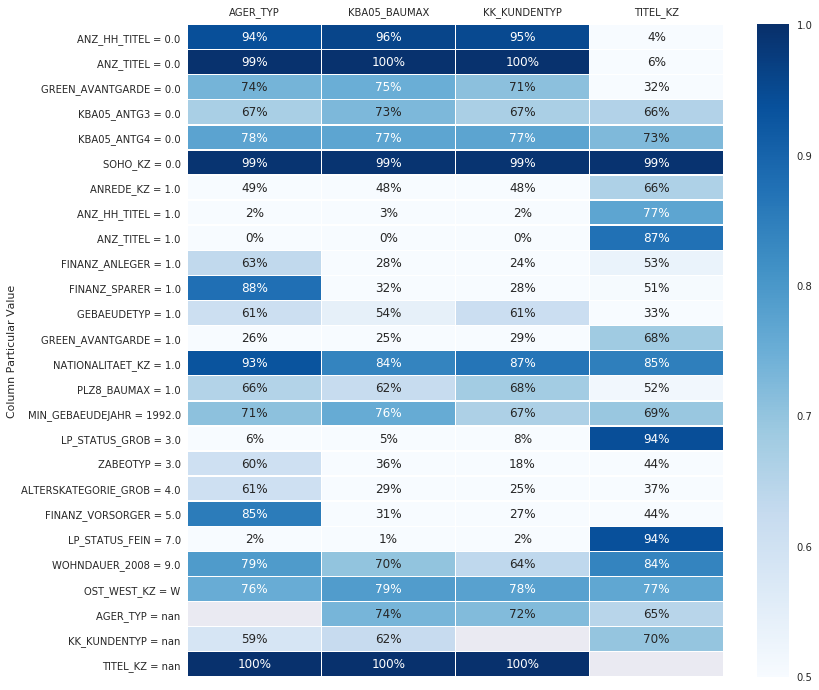

In [14]:
v_df_all['Values'] = v_df_all['Values'].astype(str)
v_item_60 = v_df_all[v_df_all['Values %'] > 0.60].copy()
v_item_60 = v_item_60.groupby(['Column Name', 'Values']).count().reset_index()[['Column Name', 'Values']]
v_item_60['key'] = 0

v_item = pd.DataFrame({ 'Base Column Name': v_nullThreshold['Column Name'] })
v_item['key'] = 0

v_item_60 = v_item_60.merge(v_item, how = 'outer')
v_item_60 = v_item_60.merge(v_df_all, how = 'left', on = ['Column Name', 'Values', 'Base Column Name'])
v_item_60 = pd.pivot_table( v_item_60, 
                            index = ['Column Name', 'Values'],
                            columns = 'Base Column Name',
                            values = ['Values %'] ).reset_index()
v_item_60.columns = [item[1] if item[0] == 'Values %' else item[0] for item in v_item_60.columns.values]
v_item_60['IsNull'] = 0
v_item_60.loc[v_item_60['Values'] == 'NaN', 'IsNull'] = 1
v_item_60.sort_values(['IsNull', 'Values', 'Column Name'], inplace = True)
v_item_60['Column Particular Value'] = v_item_60['Column Name'] + ' = ' + v_item_60['Values']
v_item_60.drop(['Column Name', 'Values', 'IsNull'], axis = 1, inplace = True)
v_item_60.set_index('Column Particular Value', inplace = True)

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap( v_item_60, annot = True, fmt = ".0%", cmap = "Blues", 
             vmin = 0.50, vmax = 1.00, linewidths=.5, ax = ax )
ax.xaxis.tick_top()
plt.show()

From the heatmaps above (the first type of heatmap) we can see that there is a high correlation between a **"column_A"** that has missing values and particular values in **"column_B"**.

We can also see that there is a high correlation between a **"column_A"** that doesn't have missing values and particular values in **"column_B"**. This finding leads me in thinking that these columns are rather MNAR (data is Missing Not at Random). 

------------------------

In order to decide which column we will drop or keep, we will check the non missing values for column **"column_A"** (where this column is to be considered one of the 4 columns where we have more than 50% of data missing). 

The first verification to be done is to check the principal values in a column **"column_B"** where we have a high correlation. The second verification is to choose one of the correlated columns and do a indepth verification on the distribution of all values (NaN values are included for both columns and always encoded as **-1**).

If we see that the same value for column **"column_A"** is having a high correlation with most of the values in **"column_B"** than we should drop the given column as the information gain will be less important than the bias which could be introduced.

If we see that the same value for column **"column_A"** is having a more or less normal distribution in the correlation with most of the values in **"column_B"** than we should keep the given column as the information gain could be important.

In [15]:
# Check correlations for column TITEL_KZ
# TITEL_KZ  - Academic title flag
#     - 0: unknown
#     - 1: Dr.
#     - 2: Dr. Dr.
#     - 3: Prof.
#     - 4: Prof. Dr.
#     - 5: other
display(calculateNotNullValueCorr(azdiasConverted, g_azdiasConverted_fillValues, 'TITEL_KZ', 60, 1500))

TITEL_KZ    No    No% Values       Column Name  Values No  Values Sum  \
562       1.0  1947  90.14      W       OST_WEST_KZ       1510        1654   
210       1.0  1947  90.14      3    LP_STATUS_GROB       1839        2034   
199       1.0  1947  90.14      7    LP_STATUS_FEIN       1831        2026   
385       1.0  1947  90.14      1         ANZ_TITEL       1705        1889   
345       1.0  1947  90.14      0           SOHO_KZ       1936        2147   
412       1.0  1947  90.14      9    WOHNDAUER_2008       1629        1814   
216       1.0  1947  90.14      1  NATIONALITAET_KZ       1641        1835   

     Values Total  Values %  
562          2160     91.29  
210          2160     90.41  
199          2160     90.38  
385          2160     90.26  
345          2160     90.17  
412          2160     89.80  
216          2160     89.43

The results above contain the following columns:
   - **"column_A"**   --> the values for the column we analyse (e.g. TITEL_KZ)
   - **Values Total** --> the number of times the "column_A" is not NaN (in this case the column is filled-in 2160 times)
   - **No** --> the number of times "column_A" has the given value (e.g. 1947) in the complete dataset
   - **No%** --> the number of times "column_A" has the given value (e.g. 90.14) in the complete dataset expressed in percents
   --------
   - **Column Name** --> the column used in the compare (e.g. OST_WEST_KZ) - we will refer to it as "column_B"
   - **Values** --> the value found in the compare column (e.g. OST_WEST_KZ = W for the first row)
   --------
   - **Values Sum** --> the number of times "column_B" has the given value when "column_A" is not NaN regarless of the values of "column_A" (e.g. 1654 for the first row)
   - **Values No**  --> the number of times we have the same combination for the values in "column_A" and "column_B" (e.g. 1510 for the first row)
   - **Values %**   --> the number of times we have the same combination for the values in "column_A" and "column_B" expressed in percents (e.g. 91.29 for the first row)

--------

The same report will be used in the analysis of the other columns having missing values more than 50% of the time.

In [16]:
displayColumnCorrValues(azdiasConverted, g_azdiasConverted_fillValues, 'TITEL_KZ', ['NATIONALITAET_KZ'])

NATIONALITAET_KZ  No%_Not Null  \
0                1         84.95   
1                2          4.46   
2                3          1.44   
3               -1          9.17   

                                                            Value_Not Null  \
0  [1.0 (89.43%) , 2.0 (0.11%) , 3.0 (2.34%) , 4.0 (2.78%) , 5.0 (5.34%) ]   
1  [1.0 (92.71%) , 2.0 (1.04%) , 3.0 (1.04%) , 4.0 (1.04%) , 5.0 (4.17%) ]   
2                              [1.0 (90.32%) , 4.0 (6.45%) , 5.0 (3.23%) ]   
3                [1.0 (95.45%) , 3.0 (2.53%) , 4.0 (1.52%) , 5.0 (0.51%) ]   

   No%_Null      Value_Null  
0     76.74  [-1 (100.0%) ]  
1      7.35  [-1 (100.0%) ]  
2      3.75  [-1 (100.0%) ]  
3     12.16  [-1 (100.0%) ]

The results above contain the following columns:
   - **"column_B"** --> the specific value for column "column_B" used in the compare (e.g. NATIONALITAET_KZ = 1 for the first row)
   --------
   - **No%_Not Null** --> the number of times "column_B" has the given value when "column_A" is not NaN (expressed in percents)
   - **Value_Not Null** --> the exact values taken by "column_A" with their percents when "column_A" is not NaN and "column_B" has the given value
   --------
   - **No%_Null** --> the number of times "column_B" has the given value when "column_A" is NaN (expressed in percents)
   - **Value_Null** --> the exact values taken by "column_A" with their percents when "column_A" is NaN and "column_B" has the given value (it will always be -1 (100.0%) as NaN values are encoded as -1

--------

The same report will be used in the analysis of the other columns having missing values more than 50% of the time.

For column **TITEL_KZ** we can see that the column is missing 99.76% of times and that when it is present there are a lot of columns with a correlation bigger than 90% only for value 1. Because of this type of distribution, I will not keep this column. 

-----------------

In [17]:
# Check correlations for column AGER_TYP
# AGER_TYP  - Best-ager typology
#     - -1: unknown
#     - 0: no classification possible
#     - 1: passive elderly
#     - 2: cultural elderly
#     - 3: experience-driven elderly
display(calculateNotNullValueCorr(azdiasConverted, g_azdiasConverted_fillValues, 'AGER_TYP', 70, 5000))

AGER_TYP     No    No% Values           Column Name  Values No  \
4376       3.0  27104  13.20      2  ALTERSKATEGORIE_GROB       5641   
2408       2.0  98472  47.95      6             SEMIO_FAM      26091   
302        1.0  79802  38.86      1            SEMIO_KAEM      10156   
2421       2.0  98472  47.95      4             SEMIO_MAT      29395   
2475       2.0  98472  47.95      2            SEMIO_KAEM      17081   
2407       2.0  98472  47.95      1             SEMIO_FAM      22190   

      Values Sum  Values Total  Values %  
4376        5929        205378     95.14  
2408       32943        205378     79.20  
302        12852        205378     79.02  
2421       38954        205378     75.46  
2475       23383        205378     73.05  
2407       31427        205378     70.61

In [18]:
displayColumnCorrValues(azdiasConverted, g_azdiasConverted_fillValues, 'AGER_TYP', ['SEMIO_KAEM'])

SEMIO_KAEM  No%_Not Null                                 Value_Not Null  \
0           1          6.26   [1.0 (79.02%) , 2.0 (13.44%) , 3.0 (7.54%) ]   
1           2         11.39  [1.0 (14.38%) , 2.0 (73.05%) , 3.0 (12.57%) ]   
2           3         27.88   [1.0 (39.23%) , 2.0 (53.94%) , 3.0 (6.82%) ]   
3           4          4.47  [1.0 (21.38%) , 2.0 (36.98%) , 3.0 (41.63%) ]   
4           5         18.92   [1.0 (51.84%) , 2.0 (42.61%) , 3.0 (5.55%) ]   
5           6         19.85   [1.0 (31.52%) , 2.0 (62.72%) , 3.0 (5.76%) ]   
6           7         11.25   [1.0 (38.4%) , 2.0 (14.11%) , 3.0 (47.49%) ]   

   No%_Null      Value_Null  
0      5.01  [-1 (100.0%) ]  
1     13.22  [-1 (100.0%) ]  
2     18.04  [-1 (100.0%) ]  
3     10.17  [-1 (100.0%) ]  
4     13.07  [-1 (100.0%) ]  
5     24.09  [-1 (100.0%) ]  
6     16.40  [-1 (100.0%) ]

For column **AGER_TYP** we can see that the column is missing 76.96% of times. We have multiple columns with different distributions for the values of column **AGER_TYP**. While checking the distribution for this column in correlation with column **SEMIO_KAEM** we can see that the values don't have outliers which would lead to choosing only one value. Because of this type of distribution, I will keep this column.

-------------------

In [19]:
# Check correlations for column KK_KUNDENTYP
# KK_KUNDENTYP  - Consumer pattern over past 12 months
#    - -1: unknown
#    - 1: regular customer
#    - 2: active customer
#    - 3: new costumer
#    - 4: stray customer
#    - 5: inactive customer
#    - 6: passive customer
display(calculateNotNullValueCorr(azdiasConverted, g_azdiasConverted_fillValues, 'KK_KUNDENTYP', 40, 1000))

KK_KUNDENTYP     No    No% Values        Column Name  Values No  \
5251           3.0  65151  21.25      1  ONLINE_AFFINITAET       4313   
5250           3.0  65151  21.25      2  ONLINE_AFFINITAET       9357   

      Values Sum  Values Total  Values %  
5251        6750        306609     63.90  
5250       17693        306609     52.89

In [20]:
displayColumnCorrValues(azdiasConverted, g_azdiasConverted_fillValues, 'KK_KUNDENTYP', ['ONLINE_AFFINITAET'])

ONLINE_AFFINITAET  No%_Not Null  \
0                 0          0.19   
1                 1          2.20   
2                 2          5.76   
3                 3         12.09   
4                 4         37.14   
5                 5         41.89   
6                -1          0.72   

                                                                              Value_Not Null  \
0      [1.0 (0.51%) , 2.0 (0.68%) , 3.0 (93.03%) , 4.0 (1.36%) , 5.0 (3.23%) , 6.0 (1.19%) ]   
1      [1.0 (0.33%) , 2.0 (3.38%) , 3.0 (63.9%) , 4.0 (1.27%) , 5.0 (12.33%) , 6.0 (18.8%) ]   
2    [1.0 (1.25%) , 2.0 (5.99%) , 3.0 (52.89%) , 4.0 (5.11%) , 5.0 (14.61%) , 6.0 (20.16%) ]   
3  [1.0 (3.66%) , 2.0 (11.69%) , 3.0 (38.95%) , 4.0 (13.45%) , 5.0 (15.78%) , 6.0 (16.46%) ]   
4  [1.0 (7.51%) , 2.0 (18.89%) , 3.0 (20.37%) , 4.0 (14.16%) , 5.0 (18.95%) , 6.0 (20.11%) ]   
5     [1.0 (24.76%) , 2.0 (27.24%) , 3.0 (9.98%) , 4.0 (17.2%) , 5.0 (13.1%) , 6.0 (7.72%) ]   
6  [1.0 (12.42%) , 2.0 (19.83%) , 3.0 (21.82%) , 4.0 (14.09%) , 5.0 (15.94%) , 6.0 (15.9%) ]   

   No%_Null      Value_Null  
0     11.14  [-1 (100.0%) ]  
1     25.62  [-1 (100.0%) ]  
2     30.82  [-1 (100.0%) ]  
3     21.62  [-1 (100.0%) ]  
4      8.70  [-1 (100.0%) ]  
5      1.65  [-1 (100.0%) ]  
6      0.45  [-1 (100.0%) ]

For column **KK_KUNDENTYP** we can see that the column is missing 65.60% of times. We have multiple columns with different distributions for the values of column **KK_KUNDENTYP**. While checking the distribution for this column in correlation with column **ONLINE_AFFINITAET** we can see that the values don't have outliers which would lead to choosing only one value. Because of this type of distribution, I will keep this column.

------------------

In [21]:
# Check correlations for column KBA05_BAUMAX
# KBA05_BAUMAX  - Most common building type within the microcell
#    - -1: unknown
#    - 0: unknown
#    - 1: mainly 1-2 family homes in the microcell
#    - 2: mainly 3-5 family homes in the microcell
#    - 3: mainly 6-10 family homes in the microcell
#    - 4: mainly 10+ family homes in the microcell
#    - 5: mainly business buildings in the microcell
display(calculateNotNullValueCorr(azdiasConverted, g_azdiasConverted_fillValues, 'KBA05_BAUMAX', 90, 70000))

KBA05_BAUMAX      No    No% Values          Column Name  Values No  \
700           1.0  208417  50.26      4          KBA05_ANTG1      91038   
699           1.0  208417  50.26      3          KBA05_ANTG1     117379   
749           1.0  208417  50.26      5           MOBI_REGIO      99285   
750           1.0  208417  50.26      4           MOBI_REGIO      80088   
492           1.0  208417  50.26      1  ANZ_HAUSHALTE_AKTIV     101239   
18            1.0  208417  50.26      5    FINANZ_MINIMALIST      89603   
701           1.0  208417  50.26      1          KBA05_ANTG2      93517   
709           1.0  208417  50.26      4            KBA05_GBZ      94655   
270           1.0  208417  50.26      4       LP_STATUS_GROB      70164   

     Values Sum  Values Total  Values %  
700       91137        414697     99.89  
699      117762        414697     99.67  
749       99985        414697     99.30  
750       82215        414697     97.41  
492      104050        414697     97.30  
18        92207        414697     97.18  
701       96726        414697     96.68  
709       98205        414697     96.39  
270       73359        414697     95.64

In [22]:
displayColumnCorrValues(azdiasConverted, g_azdiasConverted_fillValues, 'KBA05_BAUMAX', ['LP_STATUS_GROB'])

LP_STATUS_GROB  No%_Not Null  \
0              1         40.84   
1              2         19.58   
2              3          4.80   
3              4         17.68   
4              5         16.51   
5             -1          0.58   

                                                              Value_Not Null  \
0   [1.0 (8.1%) , 2.0 (3.88%) , 3.0 (27.23%) , 4.0 (19.75%) , 5.0 (41.04%) ]   
1   [1.0 (54.22%) , 2.0 (3.01%) , 3.0 (14.9%) , 4.0 (4.36%) , 5.0 (23.51%) ]   
2      [1.0 (65.1%) , 2.0 (0.8%) , 3.0 (4.13%) , 4.0 (2.46%) , 5.0 (27.5%) ]   
3    [1.0 (95.64%) , 2.0 (0.47%) , 3.0 (0.68%) , 4.0 (0.08%) , 5.0 (3.13%) ]   
4    [1.0 (96.57%) , 2.0 (0.18%) , 3.0 (0.18%) , 4.0 (0.02%) , 5.0 (3.05%) ]   
5  [1.0 (58.14%) , 2.0 (1.52%) , 3.0 (12.75%) , 4.0 (7.36%) , 5.0 (20.23%) ]   

   No%_Null      Value_Null  
0     35.30  [-1 (100.0%) ]  
1     30.57  [-1 (100.0%) ]  
2      4.42  [-1 (100.0%) ]  
3     18.80  [-1 (100.0%) ]  
4     10.39  [-1 (100.0%) ]  
5      0.51  [-1 (100.0%) ]

For column **KBA05_BAUMAX** we can see that the column is missing 53.47% of times. We have multiple columns with different distributions for the values of column **KBA05_BAUMAX**. While checking the distribution for this column in correlation with column **LP_STATUS_GROB** we can see that the values don't have outliers which would lead to choosing only one value. Because of this type of distribution, I will keep this column.

#### Discussion 1.1.2.2: Assess Missing Data in Each Column (between 16% and 50% of missing data)

In [23]:
v_nullThreshold = ( v_null[   (v_null['Missing %'] < g_nullThresholdLimit) 
                            & (v_null['Missing %'] > 16) ]
                        .sort_values('Missing %', ascending = False)
                        .reset_index(drop = True) )
display(v_nullThreshold)

Column Name  Missing %
0     GEBURTSJAHR  44.020282
1        ALTER_HH  34.813699
2             KKK  17.735668
3        REGIOTYP  17.735668
4  W_KEIT_KIND_HH  16.605084

In the plot below we will be checking if we can still find a pattern for the missing values (outliers excluded).

We can see that there are certain columns with a strong correlation between a particular value of the column and data missing in another column.

E.g.: When column "GREEN_AVANTGARDE = 0" we will have in +/-93% of times a missing value into columns KKK, REGIOTYP and W_KEIT_KIND_HH.

Also we can see that there are columns missing together.

E.g.: When column KKK is missing then column REGIOTYP is also missing in 100% of times.

In [24]:
# Investigate patterns in the amount of missing data in each column.
v_df_all = pd.DataFrame()
for item in v_nullThreshold['Column Name'].values:
    v_item, v_item_60 = calculateNullCorr(azdiasConverted, item)     
    v_item['Base Column Name'] = item    
    v_df_all = v_df_all.append(v_item.reset_index(drop = True), ignore_index = True) 

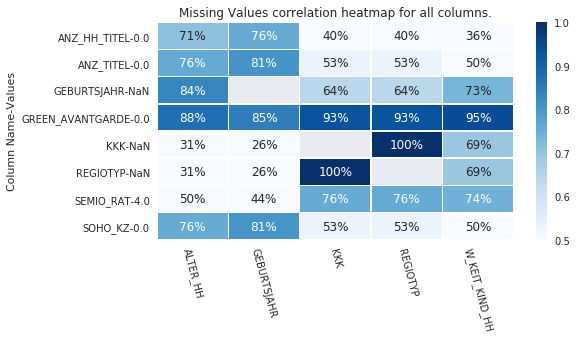

In [25]:
v_df_all['Values'] = v_df_all['Values'].astype(str).replace({'nan': 'NaN'})
v_item_60 = v_df_all[v_df_all['Values %'] > 0.75].copy()
v_item_60 = v_item_60.groupby(['Column Name', 'Values']).count().reset_index()[['Column Name', 'Values']]
v_item_60.drop(( v_item_60[v_item_60['Column Name']
                    .isin(v_null[v_null['Missing %'] >= g_nullThresholdLimit]['Column Name'])].index ), inplace = True)
v_item_60['key'] = 0

v_item = pd.DataFrame({ 'Base Column Name': v_nullThreshold['Column Name'] })
v_item['key'] = 0

v_item_60 = v_item_60.merge(v_item, how = 'outer')
v_item_60 = v_item_60.merge(v_df_all, how = 'left', on = ['Column Name', 'Values', 'Base Column Name'])
v_item_60 = pd.pivot_table( v_item_60, 
                            index = ['Column Name', 'Values'],
                            columns = 'Base Column Name',
                            values = ['Values %'] )
v_item_60.columns = [item[1] for item in v_item_60.columns.values]

f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap( v_item_60, annot = True, fmt = ".0%", cmap = "Blues", 
             vmin = 0.50, vmax = 1.00, linewidths=.5, ax = ax )
ax.set_title(f'Missing Values correlation heatmap for all columns.')
plt.xticks(rotation = -75) 
plt.show()

----------------

Remove the outlier columns from the dataset.

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
g_nullThresholdCols = ['TITEL_KZ']
azdiasConverted.drop(g_nullThresholdCols, axis = 1, inplace = True)

print(f'Number of rows    in the dataset:  {azdiasConverted.shape[0]}')
print(f'Number of columns in the dataset:  {azdiasConverted.shape[1]}')

Number of rows    in the dataset:  891221
Number of columns in the dataset:  84


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [27]:
# How much data is missing in each row of the dataset?
v_rows = azdiasConverted.isnull().astype('int')

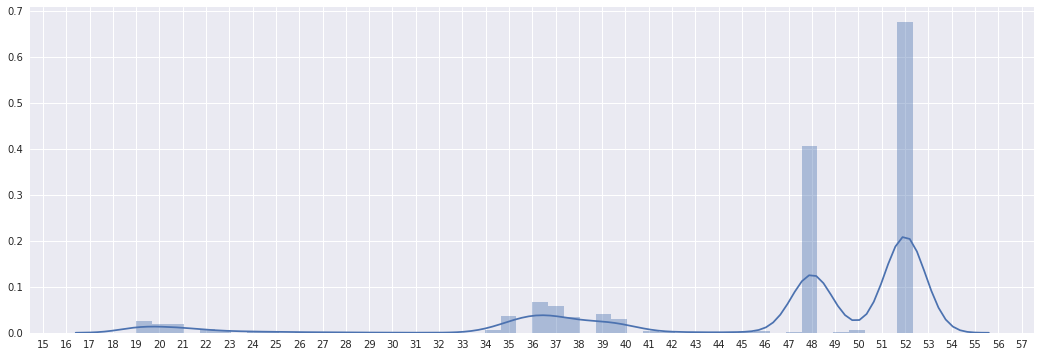

In [28]:
v_count = pd.DataFrame({'Missing Values Number': v_rows.sum(axis = 1)})

# Select only the values where we have more than 18 missing values, in order to see the picks better on the
# distribution plot visualization
v_count = v_count[v_count['Missing Values Number'] > 18] 

f, ax = plt.subplots(figsize=(18, 6))
sns.distplot(v_count, ax = ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

From the visualization of the distribution above we can see that we have the following picks:
   - for 34 missing values per row (pick 1)
   - for 48 missing values per row (pick 2)
   - for 52 missing values per row (pick 3)

I will use the threshold value for splitting the two datasets to **34**.

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
g_rowsThreshold = 34
v_rowsThreshold_02 = 48
v_rowsThreshold_03 = 52

v_rows_0 = v_rows[v_rows.sum(axis = 1) < g_rowsThreshold].copy()
v_rows_1 = v_rows[v_rows.sum(axis = 1) >= g_rowsThreshold].copy()
v_rows_1_01 = v_rows[(v_rows.sum(axis = 1) >= g_rowsThreshold) & (v_rows.sum(axis = 1) < v_rowsThreshold_02)].copy()
v_rows_1_02 = v_rows[(v_rows.sum(axis = 1) >= v_rowsThreshold_02) & (v_rows.sum(axis = 1) < v_rowsThreshold_03)].copy()
v_rows_1_03 = v_rows[(v_rows.sum(axis = 1) >= v_rowsThreshold_03)].copy()

print(f'Number of rows that have less than {g_rowsThreshold} values per row missing: {v_rows_0.shape[0]}')
print(f'Number of rows that have more than {g_rowsThreshold} values per row missing: {v_rows_1.shape[0]}')
print(f'Number of rows (Pick 1) that have between {g_rowsThreshold} and {v_rowsThreshold_02} values per row missing: {v_rows_1_01.shape[0]}')
print(f'Number of rows (Pick 2) that have between {v_rowsThreshold_02} and {v_rowsThreshold_03} values per row missing: {v_rows_1_02.shape[0]}')
print(f'Number of rows (Pick 3) that have more than {v_rowsThreshold_03} values per row missing: {v_rows_1_03.shape[0]}')

Number of rows that have less than 34 values per row missing: 798066
Number of rows that have more than 34 values per row missing: 93155
Number of rows (Pick 1) that have between 34 and 48 values per row missing: 19630
Number of rows (Pick 2) that have between 48 and 52 values per row missing: 27945
Number of rows (Pick 3) that have more than 52 values per row missing: 45580


Column NaN percentage for:
   *** Less than 34 Dataset (rows that have less than 34 values per row missing)
   *** More than 34 Dataset (rows that have more than 34 values per row missing)
   *** Pick 1 Dataset (rows that have between 34 and 48 values per row missing)
   *** Pick 2 Dataset (rows that have between 48 and 52 values per row missing)
   *** Pick 3 Dataset (rows that have more than 52 values per row missing)


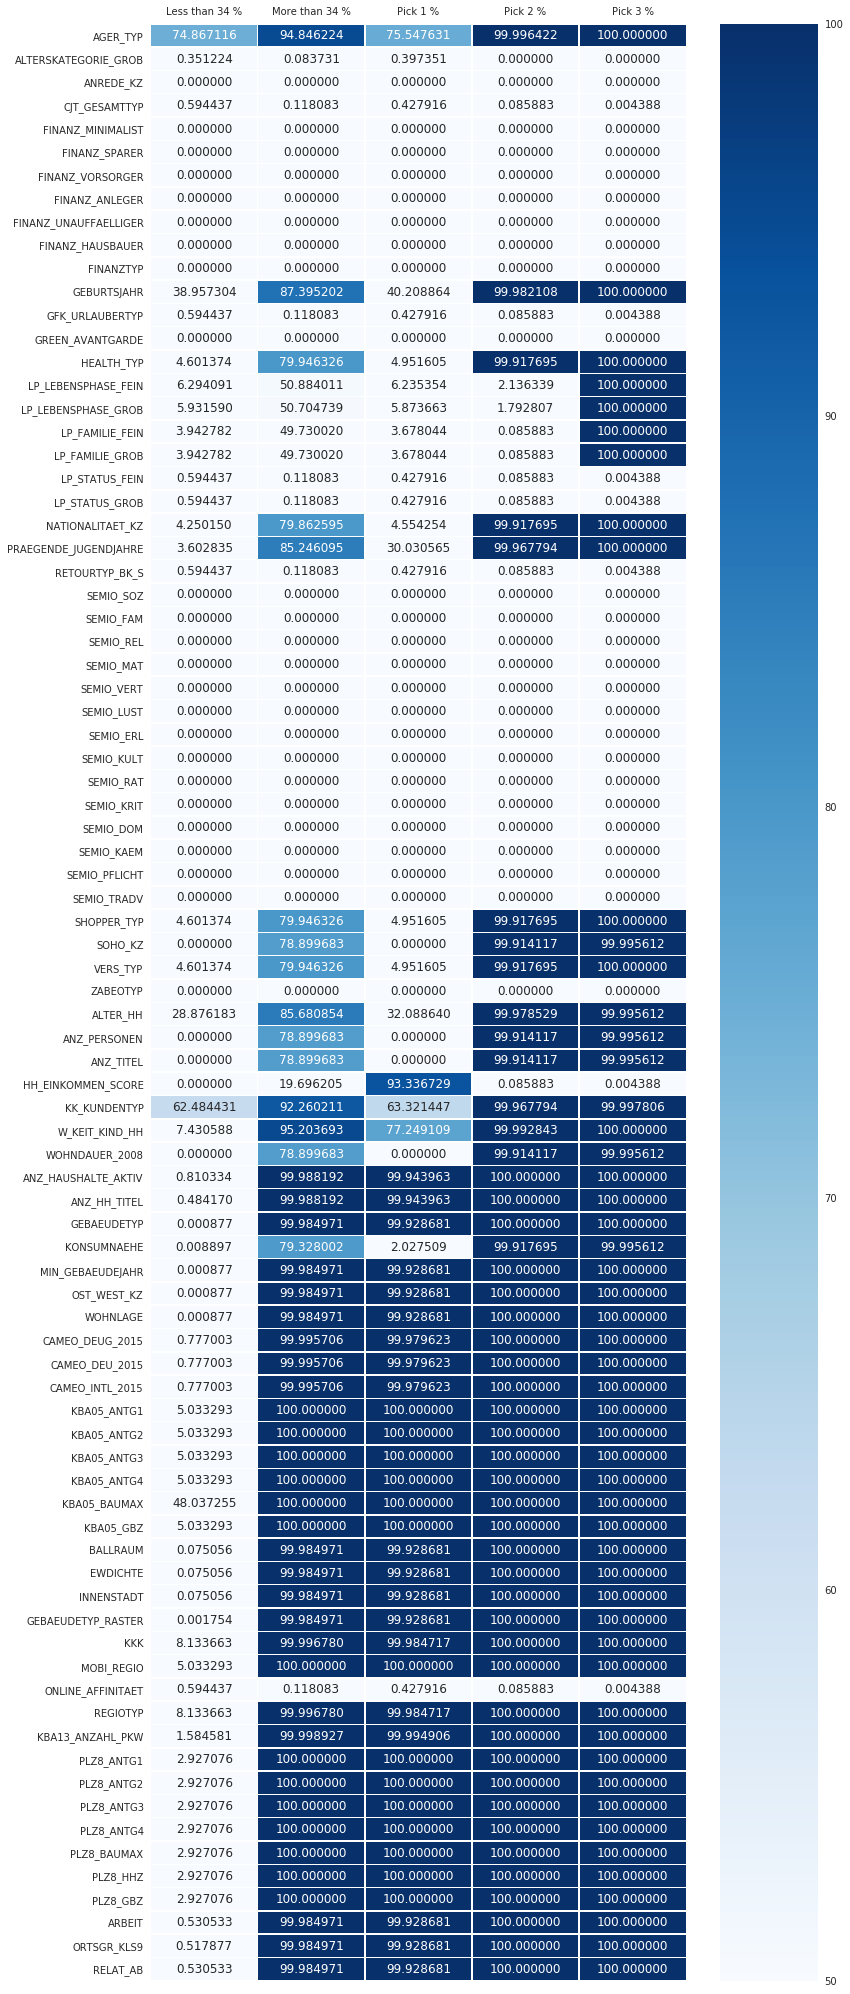

100.0    33
0.0      24
80.0      9
2.0       7
86.0      2
50.0      2
52.0      2
96.0      2
94.0      1
20.0      1
88.0      1
Name: More than 34 %, dtype: int64

In [30]:
v_rowCorr = pd.DataFrame({ f'Less than {g_rowsThreshold} %': v_rows_0.sum() / v_rows_0.shape[0] * 100,
                           f'More than {g_rowsThreshold} %': v_rows_1.sum() / v_rows_1.shape[0] * 100,
                           'Pick 1 %': v_rows_1_01.sum() / v_rows_1_01.shape[0] * 100,
                           'Pick 2 %': v_rows_1_02.sum() / v_rows_1_02.shape[0] * 100,
                           'Pick 3 %': v_rows_1_03.sum() / v_rows_1_03.shape[0] * 100 })

f, ax = plt.subplots(figsize=(12, 36))
sns.heatmap(v_rowCorr, annot = True, cmap = "Blues", fmt = "f", vmin = 50, vmax = 100, linewidths=.5, ax = ax)
ax.xaxis.tick_top()

print('Column NaN percentage for:' \
        + f'\n   *** Less than {g_rowsThreshold} Dataset (rows that have less than {g_rowsThreshold} values per row missing)' \
        + f'\n   *** More than {g_rowsThreshold} Dataset (rows that have more than {g_rowsThreshold} values per row missing)' \
        + f'\n   *** Pick 1 Dataset (rows that have between {g_rowsThreshold} and {v_rowsThreshold_02} values per row missing)' \
        + f'\n   *** Pick 2 Dataset (rows that have between {v_rowsThreshold_02} and {v_rowsThreshold_03} values per row missing)' \
        + f'\n   *** Pick 3 Dataset (rows that have more than {v_rowsThreshold_03} values per row missing)')
plt.show()

display(((v_rowCorr[f'More than {g_rowsThreshold} %'] / 2).apply(np.ceil) * 2).value_counts())

From the heatmap above we can see that for the rows where we have:
   - 4  columns for which the rows have a missing value +/- 52% of the time
   - 9  columns for which the rows have a missing value +/- 80% of the time
   - 3  column for which the rows have a missing value +/- 86% of the time
   - 3  column for which the rows have a missing value +/- 94% of the time
   - 33 columns for which the rows have a missing value +/- 99% of the time

We will analyse all the columns that have no missing values in order to check for a particular pattern in the missing data at row level (if any).

In [31]:
v_columns = v_rowCorr[v_rowCorr[f'More than {g_rowsThreshold} %'] == 0]
print(f'Columns for which we have no missing value in the dataset containing more than {g_rowsThreshold} NaN values.')
display(list(v_columns.index.values))

Columns for which we have no missing value in the dataset containing more than 34 NaN values.


['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
v_rowsValues_0 = azdiasConverted.iloc[v_rows_0.index][v_columns.index.values]
v_rowsValues_1 = azdiasConverted.iloc[v_rows_1.index][v_columns.index.values]
v_rowsValues_1_01 = azdiasConverted.iloc[v_rows_1_01.index][v_columns.index.values]
v_rowsValues_1_02 = azdiasConverted.iloc[v_rows_1_02.index][v_columns.index.values]
v_rowsValues_1_03 = azdiasConverted.iloc[v_rows_1_03.index][v_columns.index.values]

def getValuesCount(p_df):
    v_return = pd.DataFrame()    
    for item in p_df.columns.values:
        v_values = pd.DataFrame({ 'Column Name': item, 
                                  'Value Count': p_df[item].value_counts() }).reset_index()        
        v_values.columns = ['Value', 'Column Name', 'Value Count']
        v_values = v_values[['Column Name', 'Value', 'Value Count']]
        v_return = v_return.append(v_values, ignore_index = True)                
    return v_return

v_rowsValues_0 = getValuesCount(v_rowsValues_0)
v_rowsValues_1 = getValuesCount(v_rowsValues_1)
v_rowsValues_1_01 = getValuesCount(v_rowsValues_1_01)
v_rowsValues_1_02 = getValuesCount(v_rowsValues_1_02)
v_rowsValues_1_03 = getValuesCount(v_rowsValues_1_03)
v_rowsValues_dummy = v_rowsValues_0.copy()
v_rowsValues_dummy['Value Count'] = 0

v_count = ( v_rowsValues_0.merge( v_rowsValues_dummy, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=(f'Less than {g_rowsThreshold} Dataset', '_Dummy_01') ).fillna(0)
                          .merge( v_rowsValues_dummy, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=('_Dummy_01', '_Dummy_02') ).fillna(0)
                          .merge( v_rowsValues_1, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=('_Dummy_02', f'More than {g_rowsThreshold} Dataset') ).fillna(0)
                          .merge( v_rowsValues_1_01, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=(f'More than {g_rowsThreshold} Dataset', '_Pick 1 Dataset') ).fillna(0)
                          .merge( v_rowsValues_1_02, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=('_Pick 1 Dataset', '_Pick 2 Dataset') ).fillna(0)
                          .merge( v_rowsValues_1_03, 
                                  how = 'left', 
                                  on = ['Column Name', 'Value'], 
                                  suffixes=('_Pick 2 Dataset', '_Pick 3 Dataset') ).fillna(0) )

v_count.columns = [ 'Column Name', 
                    'Value', 
                    f'Less than {g_rowsThreshold} Dataset', 
                    'Dummy_01',
                    'Dummy_02',  
                    f'More than {g_rowsThreshold} Dataset', 
                    'Pick 1 Dataset', 
                    'Pick 2 Dataset', 
                    'Pick 3 Dataset' ]

display(v_count[ v_count['Pick 1 Dataset'] \
                   + v_count['Pick 2 Dataset'] \
                   + v_count['Pick 3 Dataset'] \
                   - v_count[f'More than {g_rowsThreshold} Dataset'] != 0 ])

v_count[f'Less than {g_rowsThreshold} Dataset'] = v_count[f'Less than {g_rowsThreshold} Dataset'] / v_rows_0.shape[0]
v_count[f'More than {g_rowsThreshold} Dataset'] = v_count[f'More than {g_rowsThreshold} Dataset'] / v_rows_1.shape[0]
v_count['Pick 1 Dataset'] = v_count['Pick 1 Dataset'] / v_rows_1_01.shape[0]
v_count['Pick 2 Dataset'] = v_count['Pick 2 Dataset'] / v_rows_1_02.shape[0]
v_count['Pick 3 Dataset'] = v_count['Pick 3 Dataset'] / v_rows_1_03.shape[0]
v_count['Dummy_01'] = np.NaN
v_count['Dummy_02'] = np.NaN

v_count = pd.melt(v_count, id_vars = ['Column Name', 'Value'], 
                           value_vars = [ f'Less than {g_rowsThreshold} Dataset', 
                                          f'More than {g_rowsThreshold} Dataset', 
                                          'Pick 1 Dataset', 
                                          'Pick 2 Dataset', 
                                          'Pick 3 Dataset', 
                                          'Dummy_01', 
                                          'Dummy_02' ])

Empty DataFrame
Columns: [Column Name, Value, Less than 34 Dataset, Dummy_01, Dummy_02, More than 34 Dataset, Pick 1 Dataset, Pick 2 Dataset, Pick 3 Dataset]
Index: []

Column values distribution percentage for:
   *** Less than 34 Dataset (798066 row(s) that have less than 34 values per row missing)
   *** More than 34 Dataset ( 93155 row(s) that have more than 34 values per row missing)
   *** Pick 1 Dataset ( 19630 row(s) that have between 34 and 48 values per row missing)
   *** Pick 2 Dataset ( 27945 row(s) that have between 48 and 52 values per row missing)
   *** Pick 3 Dataset ( 45580 row(s) that have more than 52 values per row missing)


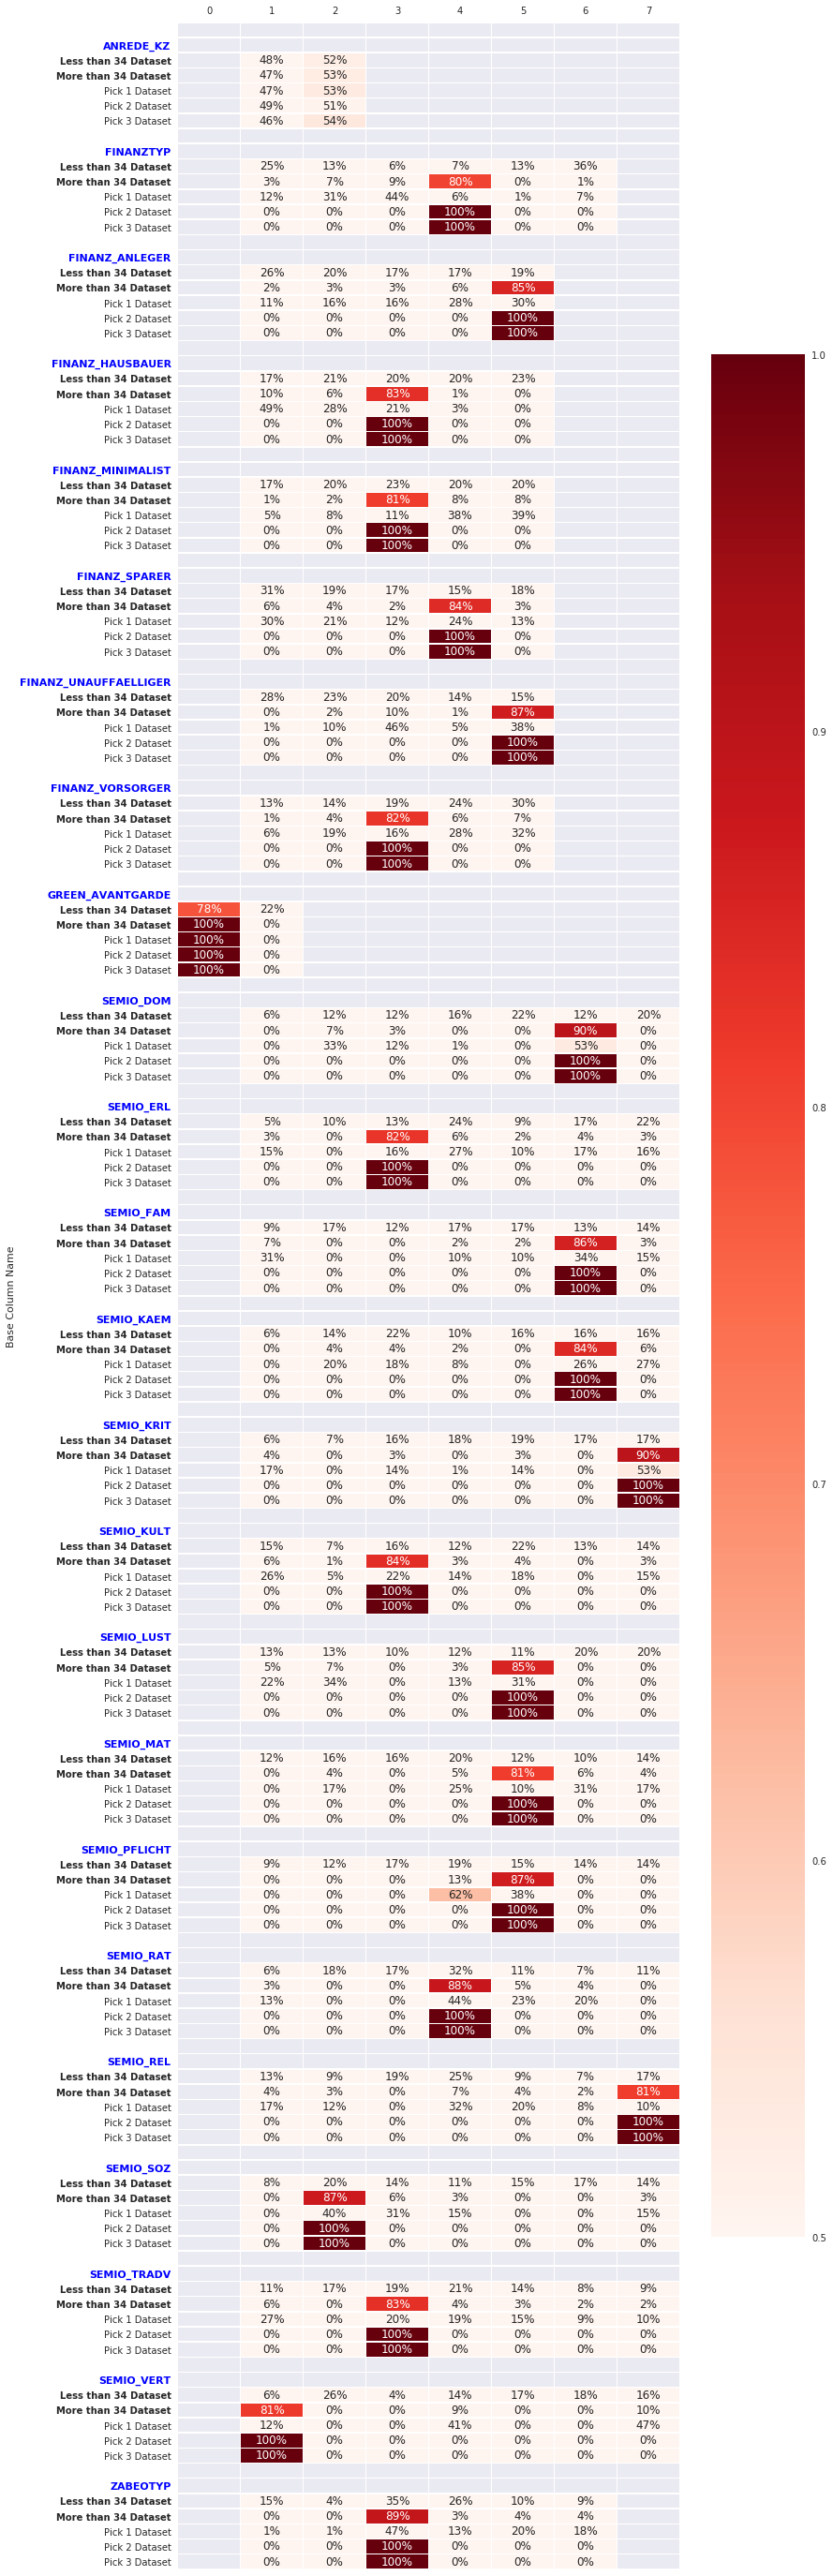

In [33]:
v_display = pd.pivot_table( v_count, 
                            index = ['Column Name', 'variable'],
                            columns = ['Value'],
                            values = ['value'] ).reset_index()
v_display['Base Column Name'] = v_display['variable']

for item in v_display[v_display['variable'] == 'Dummy_01'].index:
    v_display.loc[item, 'Base Column Name'] = ' '

for item in v_display[v_display['variable'] == 'Dummy_02'].index:
    v_display.loc[item, 'Base Column Name'] = list(v_display.loc[item, 'Column Name'])[0]

v_display.drop(['Column Name', 'variable'], level = 0, axis = 1, inplace = True)    
v_display.set_index('Base Column Name', inplace = True)
v_display.columns = [item[1] for item in v_display.columns.values]

f, ax = plt.subplots(figsize=(12, 50))
sns.heatmap( v_display, annot = True, fmt = ".0%", cmap = "Reds", 
             vmin = 0.50, vmax = 1.00, linewidths=.5, ax = ax )
ax.xaxis.tick_top()

for label in ax.get_yticklabels():
    if label.get_text() not in [ f'Less than {g_rowsThreshold} Dataset', 
                                 f'More than {g_rowsThreshold} Dataset', 
                                 'Pick 1 Dataset', 
                                 'Pick 2 Dataset', 
                                 'Pick 3 Dataset' ]:
        label.set_size(11)
        label.set_weight("bold")
        label.set_color("blue")
    elif label.get_text() in [f'Less than {g_rowsThreshold} Dataset', f'More than {g_rowsThreshold} Dataset']:
        label.set_size(10)
        label.set_weight("bold")

print('Column values distribution percentage for:' \
        + f'\n   *** Less than {g_rowsThreshold} Dataset ({str(v_rows_0.shape[0]).rjust(6, " ")} row(s) that have less than {g_rowsThreshold} values per row missing)' \
        + f'\n   *** More than {g_rowsThreshold} Dataset ({str(v_rows_1.shape[0]).rjust(6, " ")} row(s) that have more than {g_rowsThreshold} values per row missing)' \
        + f'\n   *** Pick 1 Dataset ({str(v_rows_1_01.shape[0]).rjust(6, " ")} row(s) that have between {g_rowsThreshold} and {v_rowsThreshold_02} values per row missing)' \
        + f'\n   *** Pick 2 Dataset ({str(v_rows_1_02.shape[0]).rjust(6, " ")} row(s) that have between {v_rowsThreshold_02} and {v_rowsThreshold_03} values per row missing)' \
        + f'\n   *** Pick 3 Dataset ({str(v_rows_1_03.shape[0]).rjust(6, " ")} row(s) that have more than {v_rowsThreshold_03} values per row missing)')
plt.show()

In [34]:
v_display = pd.pivot_table( v_count, 
                            index = ['Column Name', 'Value'],
                            columns = ['variable'],
                            values = ['value'] ).reset_index()
v_display.columns = [ 'Column Name', 
                      'Column Value', 
                      f'Less than {g_rowsThreshold} Dataset', 
                      f'More than {g_rowsThreshold} Dataset', 
                      'Pick 1 Dataset', 
                      'Pick 2 Dataset', 
                      'Pick 3 Dataset' ]
v_display['Deviation'] = ( v_display[f'More than {g_rowsThreshold} Dataset'] 
                             - v_display[f'Less than {g_rowsThreshold} Dataset'] ).apply(np.abs)
v_display = v_display[ (v_display[f'More than {g_rowsThreshold} Dataset'] > 0.1) 
                        & (v_display['Deviation'] > 0.3) ].reset_index(drop = True)

display(list('  - ' + v_display['Column Name'] 
                    + f' - "More than {g_rowsThreshold} Dataset" has **'
                    + (v_display[f'More than {g_rowsThreshold} Dataset'] * 100).apply(round).astype(str) 
                    + '%** of rows having value ' + v_display['Column Value'].astype(str)
                    + ' for this column and "Pick 2 Dataset" has **'
                    + (v_display[f'Pick 2 Dataset'] * 100).apply(round).astype(str) 
                    + '%** of rows having the same value ' ))

['  - FINANZTYP - "More than 34 Dataset" has **80%** of rows having value 4 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINANZ_ANLEGER - "More than 34 Dataset" has **85%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINANZ_HAUSBAUER - "More than 34 Dataset" has **83%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINANZ_MINIMALIST - "More than 34 Dataset" has **81%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINANZ_SPARER - "More than 34 Dataset" has **84%** of rows having value 4 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINANZ_UNAUFFAELLIGER - "More than 34 Dataset" has **87%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value ',
 '  - FINA

In [35]:
# Set the dataset on the subset of the data with few or no missing values
azdiasSubset = azdiasConverted.iloc[v_rows_0.index].copy()
azdiasSubset.reset_index(drop = True, inplace = True)

print(f'Number of rows    in the dataset: {azdiasSubset.shape[0]}')
print(f'Number of columns in the dataset: {azdiasSubset.shape[1]}')
display(azdiasSubset.head())

Number of rows    in the dataset: 798066
Number of columns in the dataset: 84


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   
3       NaN                   3.0          1            5.0   
4       3.0                   1.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   
3                  4              3                 4               1   
4                  3              1                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      4                 5    ...            2.0         3.0   
1                      3                 5    ...            3.0         3.0   
2                      1                 2    ...            2.0         2.0   
3                      3                 2    ...            2.0         4.0   
4                      2                 5    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         2.0         1.0          1.0       5.0       4.0     3.0   
1         1.0         0.0          1.0       4.0       4.0     3.0   
2         2.0         0.0          1.0       3.0       4.0     2.0   
3         2.0         1.0          2.0       3.0       3.0     4.0   
4         1.0         1.0          1.0       5.0       5.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          5.0       4.0  
1          5.0       2.0  
2          3.0       3.0  
3          6.0       5.0  
4          3.0       3.0  

[5 rows x 84 columns]

#### Discussion 1.1.3: Assess Missing Data in Each Row

When checking the above heatmap we can see that for the rows where we have more than 34 missing values, we have a definite pattern for certain columns:

-------------------

   - ANREDE_KZ - the distribution for "More than 34 Dataset" and "Less than 34 Dataset" follow the same trend 
-------------------

   - GREEN_AVANTGARDE - "More than 34 Dataset" has **100%** of rows having value 0 for this column and "Pick 2 Dataset" has **100%** of rows having the same value
   - FINANZTYP - "More than 34 Dataset" has **80%** of rows having value 4 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_ANLEGER - "More than 34 Dataset" has **85%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_HAUSBAUER - "More than 34 Dataset" has **83%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_MINIMALIST - "More than 34 Dataset" has **81%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_SPARER - "More than 34 Dataset" has **84%** of rows having value 4 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_UNAUFFAELLIGER - "More than 34 Dataset" has **87%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - FINANZ_VORSORGER - "More than 34 Dataset" has **82%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_DOM - "More than 34 Dataset" has **90%** of rows having value 6 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_ERL - "More than 34 Dataset" has **82%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_FAM - "More than 34 Dataset" has **86%** of rows having value 6 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_KAEM - "More than 34 Dataset" has **84%** of rows having value 6 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_KRIT - "More than 34 Dataset" has **90%** of rows having value 7 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_KULT - "More than 34 Dataset" has **84%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_LUST - "More than 34 Dataset" has **85%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_MAT - "More than 34 Dataset" has **81%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_PFLICHT - "More than 34 Dataset" has **87%** of rows having value 5 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_RAT - "More than 34 Dataset" has **88%** of rows having value 4 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_REL - "More than 34 Dataset" has **81%** of rows having value 7 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_SOZ - "More than 34 Dataset" has **87%** of rows having value 2 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_TRADV - "More than 34 Dataset" has **83%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - SEMIO_VERT - "More than 34 Dataset" has **81%** of rows having value 1 for this column and "Pick 2 Dataset" has **100%** of rows having the same value 
   - ZABEOTYP - "More than 34 Dataset" has **89%** of rows having value 3 for this column and "Pick 2 Dataset" has **100%** of rows having the same value

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?
display(feat_info.groupby('type').count())
display(feat_info[feat_info['type'].isin(['categorical', 'mixed'])])

information_level  missing_or_unknown
type                                              
categorical                 21                  21
interval                     1                   1
mixed                        7                   7
numeric                      7                   7
ordinal                     49                  49

information_level         type missing_or_unknown
attribute                                                              
AGER_TYP                         person  categorical             [-1,0]
ANREDE_KZ                        person  categorical             [-1,0]
CJT_GESAMTTYP                    person  categorical                [0]
FINANZTYP                        person  categorical               [-1]
GFK_URLAUBERTYP                  person  categorical                 []
GREEN_AVANTGARDE                 person  categorical                 []
LP_LEBENSPHASE_FEIN              person        mixed                [0]
LP_LEBENSPHASE_GROB              person        mixed                [0]
LP_FAMILIE_FEIN                  person  categorical                [0]
LP_FAMILIE_GROB                  person  categorical                [0]
LP_STATUS_FEIN                   person  categorical                [0]
LP_STATUS_GROB                   person  categorical                [0]
NATIONALITAET_KZ                 person  categorical             [-1,0]
PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
SHOPPER_TYP                      person  categorical               [-1]
SOHO_KZ                          person  categorical               [-1]
TITEL_KZ                         person  categorical             [-1,0]
VERS_TYP                         person  categorical               [-1]
ZABEOTYP                         person  categorical             [-1,9]
KK_KUNDENTYP                  household  categorical               [-1]
GEBAEUDETYP                    building  categorical             [-1,0]
OST_WEST_KZ                    building  categorical               [-1]
WOHNLAGE                       building        mixed               [-1]
CAMEO_DEUG_2015           microcell_rr4  categorical             [-1,X]
CAMEO_DEU_2015            microcell_rr4  categorical               [XX]
CAMEO_INTL_2015           microcell_rr4        mixed            [-1,XX]
KBA05_BAUMAX              microcell_rr3        mixed             [-1,0]
PLZ8_BAUMAX              macrocell_plz8        mixed             [-1,0]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def selectColumnValues(p_type, p_df):
    v_columns = list(feat_info[feat_info['type'] == p_type].index.values)        
    v_columns = [item for item in v_columns if item in p_df.columns.values]

    v_values = getValuesCount(p_df[v_columns])
    v_values = ( v_values.groupby('Column Name')
                         .agg({ 'Value': ['count', (lambda x: list(x)) ]}) )
    v_values.columns = ['Value Count', 'Value List']
    v_values.sort_values('Value Count', inplace = True)
    
    v_values['Value List'] = v_values['Value List'].apply(sorted)

    return v_values

v_values = selectColumnValues('categorical', azdiasSubset)
display(v_values)

Value Count  \
Column Name                     
ANREDE_KZ                   2   
SOHO_KZ                     2   
OST_WEST_KZ                 2   
GREEN_AVANTGARDE            2   
VERS_TYP                    2   
AGER_TYP                    3   
NATIONALITAET_KZ            3   
SHOPPER_TYP                 4   
LP_STATUS_GROB              5   
LP_FAMILIE_GROB             5   
KK_KUNDENTYP                6   
FINANZTYP                   6   
CJT_GESAMTTYP               6   
ZABEOTYP                    6   
GEBAEUDETYP                 7   
CAMEO_DEUG_2015             9   
LP_STATUS_FEIN             10   
LP_FAMILIE_FEIN            11   
GFK_URLAUBERTYP            12   
CAMEO_DEU_2015             44   

                                                                                                                                                                                        Value List  
Column Name                                                                                                                                                                                         
ANREDE_KZ                                                                                                                                                                               [1.0, 2.0]  
SOHO_KZ                                                                                                                                                                                 [0.0, 1.0]  
OST_WEST_KZ                                                                                                                                                                                 [O, W]  
GREEN_AVANTGARDE                                                                                                                                                                        [0.0, 1.0]  
VERS_TYP                                                                                                                                                                                [1.0, 2.0]  
AGER_TYP                                                                                                                                                                           [1.0, 2.0, 3.0]  
NATIONALITAET_KZ                                                                                                                                                                   [1.0, 2.0, 3.0]  
SHOPPER_TYP                                                                                                                                                                   [0.0, 1.0, 2.0, 3.0]  
LP_STATUS_GROB                                                                                                                                                           [1.0, 2.0, 3.0, 4.0, 5.0]  
LP_FAMILIE_GROB                                                                                                                                                          [1.0, 2.0, 3.0, 4.0, 5.0]  
KK_KUNDENTYP                                                                                                                                                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  
FINANZTYP                                                                                                                                                           [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  
CJT_GESAMTTYP                                                                                                                                                       [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  
ZABEOTYP                                                                                                                                                            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  
GEBAEUDETYP                                                                                                                                

In [38]:
print(f"The binary categorical variables are: {list(v_values[v_values['Value Count'] == 2].index.values)}")

The binary categorical variables are: ['ANREDE_KZ', 'SOHO_KZ', 'OST_WEST_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP']


In [39]:
# Re-encode categorical variable(s) to be kept in the analysis.
g_getDummies = ['OST_WEST_KZ']
azdiasEncoded = pd.get_dummies(azdiasSubset, columns = g_getDummies)

In [40]:
print(f"The multi-level categorical variables are: {list(v_values[v_values['Value Count'] != 2].index.values)}")

The multi-level categorical variables are: ['AGER_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'KK_KUNDENTYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']


In [41]:
v_columns = ['CAMEO_DEU_2015']

display(azdiasEncoded[v_columns].head(3))
print(f"Before re-encoding non-binary columns: {v_columns}.\n\n")

g_encoder = {}
for item in v_columns:
    v_list = v_values.loc[item, 'Value List']
    print(f'Re-encode column {item} for old values {v_list}.') 
    v_idx = azdiasEncoded[azdiasEncoded[item].notnull()].index   
    g_encoder[item] = { "LabelEncoder":  LabelEncoder(),
                        "OneHotEncoder": OneHotEncoder() }
    
    v_list = azdiasEncoded.loc[v_idx, item].values
    g_encoder[item]["LabelEncoder"].fit(v_list.ravel())    
    v_list = g_encoder[item]["LabelEncoder"].transform(v_list.ravel()).reshape(-1, 1)
    
    g_encoder[item]["OneHotEncoder"].fit(v_list)        
    v_encoded = g_encoder[item]["OneHotEncoder"].transform(v_list).toarray()
    
    v_dfOneHot = pd.DataFrame(v_encoded, columns = [f"{item}_{i}" for i in range(v_encoded.shape[1])])
    azdiasEncoded = pd.concat([azdiasEncoded, v_dfOneHot], axis = 1)
    azdiasEncoded.drop(item, axis = 1, inplace = True)

v_columns = [item for key in g_encoder.keys() for item in azdiasEncoded.columns.values if key in item ]    
display(azdiasEncoded[v_columns].head())
print(f"\nAfter re-encoding non-binary columns.")

azdiasSubset = azdiasEncoded.copy(3)

CAMEO_DEU_2015
0             8A
1             4C
2             2A

Before re-encoding non-binary columns: ['CAMEO_DEU_2015'].


Re-encode column CAMEO_DEU_2015 for old values ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'].


CAMEO_DEU_2015_0  CAMEO_DEU_2015_1  CAMEO_DEU_2015_2  CAMEO_DEU_2015_3  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   CAMEO_DEU_2015_4  CAMEO_DEU_2015_5  CAMEO_DEU_2015_6  CAMEO_DEU_2015_7  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               1.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   CAMEO_DEU_2015_8  CAMEO_DEU_2015_9        ...          CAMEO_DEU_2015_34  \
0               0.0               0.0        ...                        0.0   
1               0.0               0.0        ...                        0.0   
2               0.0               0.0        ...                        0.0   
3               0.0               0.0        ...                        0.0   
4               0.0               0.0        ...                        0.0   

   CAMEO_DEU_2015_35  CAMEO_DEU_2015_36  CAMEO_DEU_2015_37  CAMEO_DEU_2015_38  \
0                1.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                1.0                0.0   

   CAMEO_DEU_2015_39  CAMEO_DEU_2015_40  CAMEO_DEU_2015_41  CAMEO_DEU_2015_42  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_43  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 44 columns]


After re-encoding non-binary columns.


#### Discussion 1.2.1: Re-Encode Categorical Features

The binary categorical variables that contain numeric values are: 'ANREDE_KZ', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP'. For these values, no operation has been done.

The binary categorical variables that contain non-numeric values is 'OST_WEST_KZ'. This variable has been encoded using the get_dummies method.

The multi-level categorical variables are: 'AGER_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'KK_KUNDENTYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015'.

The only multi-level categorical variable which contains non-numeric values is 'CAMEO_DEU_2015' and we have re-encoded it using the OneHotEncoder method.

We will keep all the variables in the analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
v_values = selectColumnValues('mixed', azdiasSubset)
display(v_values)

Value Count  \
Column Name                          
KBA05_BAUMAX                     5   
PLZ8_BAUMAX                      5   
WOHNLAGE                         8   
LP_LEBENSPHASE_GROB             12   
PRAEGENDE_JUGENDJAHRE           15   
CAMEO_INTL_2015                 21   
LP_LEBENSPHASE_FEIN             40   

                                                                                                                                                                                                                    Value List  
Column Name                                                                                                                                                                                                                     
KBA05_BAUMAX                                                                                                                                                                                         [1.0, 2.0, 3.0, 4.0, 5.0]  
PLZ8_BAUMAX                                                                                                                                                                                          [1.0, 2.0, 3.0, 4.0, 5.0]  
WOHNLAGE                                                                                                                                                                              [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]  
LP_LEBENSPHASE_GROB                                                                                                                                            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]  
PRAEGENDE_JUGENDJAHRE                                                                                                                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]  
CAMEO_INTL_2015                                                                                                                           [12, 13, 14, 15, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 43, 44, 45, 51, 52, 54, 55]  
LP_LEBENSPHASE_FEIN    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, ...

In [43]:
azdiasEncoded = azdiasSubset.copy()

def split_Column(p_col, p_x, p_case):
    if str(p_x) == 'nan': return p_x
    
    if p_col == 'PRAEGENDE_JUGENDJAHRE':
        if p_case == 'Stream': return 0 if p_x in [1, 3, 5, 8, 10, 12, 14] else 1
        return 1940 if p_x in [1, 2] \
                 else 1950 if p_x in [3, 4] \
                 else 1960 if p_x in [5, 6, 7] \
                 else 1970 if p_x in [8, 9] \
                 else 1980 if p_x in [10, 11, 12, 13] else 1990

    elif p_col == 'CAMEO_INTL_2015':
        if p_case == 'Wealth': return str(p_x)[0]
        return str(p_x)[1]
    
    elif p_col == 'PLZ8_BAUMAX':
        if p_case == 'Business': return 1 if p_x == 5 else 0
        return 0 if p_x == 5 else p_x
    
    elif p_col == 'WOHNLAGE':
        if p_case == 'Rural': return 1 if p_x in [7, 8] else 0
        return 0 if p_x in [7, 8] else p_x
    
    elif p_col == 'LP_LEBENSPHASE_FEIN':
        if p_case == 'Earners': 
            if p_x in [1, 2, 5, 6, 21, 14, 15, 24, 29, 31]: return 0
            elif p_x in [3, 4, 7, 8, 22, 16, 25, 30, 32]: return 1
            elif p_x in [10, 11, 12, 18, 19, 27, 34, 37, 38]: return 2
            elif p_x in [13, 23, 20, 28, 35, 39, 40]: return 3
            elif p_x in [9, 17, 26, 33, 36]: return 4
            else: return -1
        
        if p_x in [1, 2, 5, 6, 21, 3, 4, 7, 8, 22, 10, 11, 12, 13, 23, 9]: return 0
        elif p_x in [14, 15, 16, 18, 19, 20, 17]: return 1
        elif p_x in [24, 25, 26, 27, 28]: return 2
        elif p_x in [29, 30, 34, 35, 33]: return 3
        elif p_x in [31, 32, 37, 38, 39, 40, 36]: return 4
        else: return -1
    
    return np.NaN

def reEncodeColumn(p_col, p_list, p_debug = True):
    for item in p_list:
        azdiasEncoded[f'{p_col}_{item}'] = azdiasEncoded[f'{p_col}'].apply(lambda x: split_Column(p_col, x, item))    
    
    v_list = sorted([item for item in azdiasEncoded.columns.values if p_col.lower() in item.lower()])    
    v_check = getValuesCount( pd.DataFrame( azdiasEncoded[v_list[0]].astype(str)
                                              + '_' + azdiasEncoded[v_list[1]].astype(str)
                                              + '_' + azdiasEncoded[v_list[2]].astype(str) ) )    
    azdiasEncoded.drop(p_col, axis = 1, inplace = True)
    
    if p_debug:
        display(v_check.sort_values('Value').reset_index(drop = True))
    
    return

In [44]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) 
#    - -1: unknown 
#    - 0: unknown 
#    - 1: 40s - war years (Mainstream, E+W) 
#    - 2: 40s - reconstruction years (Avantgarde, E+W) 
#    - 3: 50s - economic miracle (Mainstream, E+W) 
#    - 4: 50s - milk bar / Individualisation (Avantgarde, E+W) 
#    - 5: 60s - economic miracle (Mainstream, E+W) 
#    - 6: 60s - generation 68 / student protestors (Avantgarde, W) 
#    - 7: 60s - opponents to the building of the Wall (Avantgarde, E) 
#    - 8: 70s - family orientation (Mainstream, E+W) 
#    - 9: 70s - peace movement (Avantgarde, E+W) 
#    - 10: 80s - Generation Golf (Mainstream, W) 
#    - 11: 80s - ecological awareness (Avantgarde, W) 
#    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E) 
#    - 13: 80s - Swords into ploughshares (Avantgarde, E) 
#    - 14: 90s - digital media kids (Mainstream, E+W) 
#    - 15: 90s - ecological awareness (Avantgarde, E+W)

reEncodeColumn('PRAEGENDE_JUGENDJAHRE', ['Stream', 'Decade'])


Column Name            Value  Value Count
0             0   1.0_1940.0_0.0        20679
1             0  10.0_1980.0_0.0        85808
2             0  11.0_1980.0_1.0        35752
3             0  12.0_1980.0_0.0        24446
4             0  13.0_1980.0_1.0         5764
5             0  14.0_1990.0_0.0       182985
6             0  15.0_1990.0_1.0        42546
7             0   2.0_1940.0_1.0         7479
8             0   3.0_1950.0_0.0        53848
9             0   4.0_1950.0_1.0        20451
10            0   5.0_1960.0_0.0        84694
11            0   6.0_1960.0_1.0        25652
12            0   7.0_1960.0_1.0         4010
13            0   8.0_1970.0_0.0       141629
14            0   9.0_1970.0_1.0        33570
15            0      nan_nan_nan        28753

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# German CAMEO: Wealth / Life Stage Typology, mapped to international code 
#   - -1: unknown 
#   - 11: Wealthy Households - Pre-Family Couples & Singles 
#   - 12: Wealthy Households - Young Couples With Children 
#   - 13: Wealthy Households - Families With School Age Children 
#   - 14: Wealthy Households - Older Families & Mature Couples 
#   - 15: Wealthy Households - Elders In Retirement 
#   - 21: Prosperous Households - Pre-Family Couples & Singles 
#   - 22: Prosperous Households - Young Couples With Children 
#   - 23: Prosperous Households - Families With School Age Children 
#   - 24: Prosperous Households - Older Families & Mature Couples 
#   - 25: Prosperous Households - Elders In Retirement 
#   - 31: Comfortable Households - Pre-Family Couples & Singles 
#   - 32: Comfortable Households - Young Couples With Children 
#   - 33: Comfortable Households - Families With School Age Children 
#   - 34: Comfortable Households - Older Families & Mature Couples 
#   - 35: Comfortable Households - Elders In Retirement 
#   - 41: Less Affluent Households - Pre-Family Couples & Singles 
#   - 42: Less Affluent Households - Young Couples With Children 
#   - 43: Less Affluent Households - Families With School Age Children 
#   - 44: Less Affluent Households - Older Families & Mature Couples 
#   - 45: Less Affluent Households - Elders In Retirement 
#   - 51: Poorer Households - Pre-Family Couples & Singles 
#   - 52: Poorer Households - Young Couples With Children 
#   - 53: Poorer Households - Families With School Age Children 
#   - 54: Poorer Households - Older Families & Mature Couples 
#   - 55: Poorer Households - Elders In Retirement 
#   - XX: unknown

reEncodeColumn('CAMEO_INTL_2015', ['Wealth', 'Typology'])


Column Name        Value  Value Count
0             0       12_2_1        13249
1             0       13_3_1        26335
2             0       14_4_1        62884
3             0       15_5_1        16974
4             0       22_2_2        33154
5             0       23_3_2        26750
6             0       24_4_2        91158
7             0       25_5_2        39627
8             0       31_1_3        19023
9             0       32_2_3        10354
10            0       33_3_3         9935
11            0       34_4_3        18524
12            0       35_5_3        10356
13            0       41_1_4        92336
14            0       43_3_4        56672
15            0       44_4_4        14820
16            0       45_5_4        26132
17            0       51_1_5       133694
18            0       52_2_5        20542
19            0       54_4_5        45391
20            0       55_5_5        23955
21            0  nan_nan_nan         6201

In [46]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
# Most common building type within the PLZ8 region 
#   - -1: unknown 
#   - 0: unknown 
#   - 1: mainly 1-2 family homes 
#   - 2: mainly 3-5 family homes 
#   - 3: mainly 6-10 family homes 
#   - 4: mainly 10+ family homes 
#   - 5: mainly business buildings

reEncodeColumn('PLZ8_BAUMAX', ['Business', 'Families_No'])


Column Name        Value  Value Count
0            0  1.0_0.0_1.0       499550
1            0  2.0_0.0_2.0        70407
2            0  3.0_0.0_3.0        50732
3            0  4.0_0.0_4.0        56684
4            0  5.0_1.0_0.0        97333
5            0  nan_nan_nan        23360

In [47]:
# Investigate "LP_LEBENSPHASE_FEIN" and engineer two new variables.
# Life stage, fine scale

#   - 1:  low-income earners - single  - younger age
#   - 2:  low-income earners - single  - middle age
#   - 5:  low-income earners - single  - advanced age
#   - 6:  low-income earners - single  - retirement age
#   - 21: low-income earners - single  - parent 
#   - 3:  average earners    - single  - younger age
#   - 4:  average earners    - single  - middle age
#   - 7:  average earners    - single  - advanced age
#   - 8:  average earners    - single  - retirement age
#   - 22: average earners    - single  - parent 
#   - 10: homeowners         - single  - wealthy 
#   - 11: homeowners         - single  - advanced age
#   - 12: homeowners         - single  - retirement age
#   - 13: top earners        - single  - higher age
#   - 23: top earners        - single  - parent
#   - 9:  independent        - single  - persons

#   - 14: low-income earners - couples - younger age
#   - 15: low-income earners - couples - higher age
#   - 14: average earners    - couples - younger age
#   - 16: average earners    - couples - higher age
#   - 18: homeowners         - couples - wealthy - younger age
#   - 19: homeowners         - couples - higher age
#   - 20: top earners        - couples - higher age
#   - 17: independent        - couples

#   - 24: low-income earners - families
#   - 25: average earners    - families
#   - 27: homeowners         - families
#   - 28: top earners        - families
#   - 26: independent        - families

#   - 29: low-income earners - multiperson households - younger age 
#   - 30: average earners    - multiperson households - younger age 
#   - 34: homeowners         - multiperson households - younger
#   - 35: top earners        - multiperson households - younger age 
#   - 33: independent        - multiperson households - younger age 

#   - 31: low-income earners - multiperson households - higher age 
#   - 32: average earners    - multiperson households - higher age 
#   - 37: homeowners         - multiperson households - advanced
#   - 38: homeowners         - multiperson households - retirement
#   - 39: top earners        - multiperson households - middle age
#   - 40: top earners        - multiperson households - retirement age 
#   - 36: independent        - multiperson households - higher age 

# From the distribution above we can see that we can create 2 variables:
#    - earners level: low-income / average / homeowners / top earners / independent
#    - person status: single / couples / families / multiperson households - younger age / multiperson households - higher age

reEncodeColumn('LP_LEBENSPHASE_FEIN', ['Earners', 'Status'])


Column Name         Value  Value Count
0             0   1.0_0.0_0.0        58723
1             0  10.0_2.0_0.0        24476
2             0  11.0_2.0_0.0        25374
3             0  12.0_2.0_0.0        22281
4             0  13.0_3.0_0.0        24811
5             0  14.0_0.0_1.0        16355
6             0  15.0_0.0_1.0        18967
7             0  16.0_1.0_1.0        13634
8             0  17.0_4.0_1.0         5487
9             0  18.0_2.0_1.0         6806
10            0  19.0_2.0_1.0        18586
11            0   2.0_0.0_0.0        37149
12            0  20.0_3.0_1.0        16287
13            0  21.0_0.0_0.0        11967
14            0  22.0_1.0_0.0         6831
15            0  23.0_3.0_0.0         8631
16            0  24.0_0.0_2.0        11311
17            0  25.0_1.0_2.0         9850
18            0  26.0_4.0_2.0         3368
19            0  27.0_2.0_2.0        13805
20            0  28.0_3.0_2.0        11547
21            0  29.0_0.0_3.0        24881
22            0   3.0_1.0_0.0        18757
23            0  30.0_1.0_3.0        21150
24            0  31.0_0.0_4.0        22261
25            0  32.0_1.0_4.0        15769
26            0  33.0_4.0_3.0         5724
27            0  34.0_2.0_3.0        12422
28            0  35.0_3.0_3.0        13012
29            0  36.0_4.0_4.0         9657
30            0  37.0_2.0_4.0        17500
31            0  38.0_2.0_4.0        13101
32            0  39.0_3.0_4.0        15132
33            0   4.0_1.0_0.0        16478
34            0  40.0_3.0_4.0        14110
35            0   5.0_0.0_0.0        52400
36            0   6.0_0.0_0.0        43334
37            0   7.0_1.0_0.0        24950
38            0   8.0_1.0_0.0        28839
39            0   9.0_4.0_0.0        12112
40            0   nan_nan_nan        50231

In [48]:
# Investigate "WOHNLAGE" and engineer two new variables.
# Neighborhood quality (or rural flag)
#   - 1: unknown
#   - 0: no score calculated
#   - 1: very good neighborhood
#   - 2: good neighborhood
#   - 3: average neighborhood
#   - 4: poor neighborhood
#   - 5: very poor neighborhood
#   - 7: rural neighborhood
#   - 8: new building in rural neighborhood

reEncodeColumn('WOHNLAGE', ['Rural', 'Quality'])


Column Name        Value  Value Count
0            0  0.0_0.0_0.0         6944
1            0  1.0_1.0_0.0        43917
2            0  2.0_2.0_0.0       100376
3            0  3.0_3.0_0.0       249719
4            0  4.0_4.0_0.0       135971
5            0  5.0_5.0_0.0        74346
6            0  7.0_0.0_1.0       169315
7            0  8.0_0.0_1.0        17471
8            0  nan_nan_nan            7

#### Discussion 1.2.2: Engineer Mixed-Type Features

-------------------------------

For column **PRAEGENDE_JUGENDJAHRE** I have created two variables with the following encoding:
   - **PRAEGENDE_JUGENDJAHRE_Stream**
      - 0 if initial value was linked to Mainstream
      - 1 if initial value was linked to Avantgarde
   - **PRAEGENDE_JUGENDJAHRE_Decade**
      - 1940 if initial value was linked to 40s
      - 1950 if initial value was linked to 50s
      - 1960 if initial value was linked to 60s
      - 1970 if initial value was linked to 70s
      - 1980 if initial value was linked to 80s
      - 1990 if initial value was linked to 90s

-------------------------------

For column **CAMEO_INTL_2015** I have created two variables with an encoding based on the pattern existing at the variable level:
   - **CAMEO_INTL_2015_Wealth**
      - 1 if initial value was linked to Wealthy Households
      - 2 if initial value was linked to Prosperous Households
      - 3 if initial value was linked to Comfortable Households
      - 4 if initial value was linked to Less Affluent Households
      - 5 if initial value was linked to Poorer Households
   - **CAMEO_INTL_2015_Typology**
      - 1 if initial value was linked to Pre-Family Couples & Singles
      - 2 if initial value was linked to Young Couples With Children
      - 3 if initial value was linked to Families With School Age Children
      - 4 if initial value was linked to Older Families & Mature Couples
      - 5 if initial value was linked to Elders In Retirement

-------------------------------

For column **PLZ8_BAUMAX** I have created two variables with an encoding based on the pattern existing at the variable level:
   - **PLZ8_BAUMAX_Business**
      - 0 if initial value was linked to family homes
      - 1 if initial value was linked to business buildings
   - **PLZ8_BAUMAX_Families_No**
      - 0 if initial value was linked to business buildings
      - 1: mainly 1-2 family homes 
      - 2: mainly 3-5 family homes 
      - 3: mainly 6-10 family homes 
      - 4: mainly 10+ family homes 
      
-------------------------------

For column **LP_LEBENSPHASE_FEIN** I have created two variables with an encoding based on the pattern existing at the variable level:
   - **LP_LEBENSPHASE_FEIN_Earners**
      - 0 if initial value was linked to low-income earners
      - 1 if initial value was linked to average earners
      - 2 if initial value was linked to homeowners
      - 3 if initial value was linked to top earners
      - 4 if initial value was linked to independent
   - **LP_LEBENSPHASE_FEIN_Status**
      - 0 if initial value was linked to single persons 
      - 1 if initial value was linked to couples
      - 2 if initial value was linked to families 
      - 3 if initial value was linked to multiperson households younger age
      - 4 if initial value was linked to multiperson households higher age 
      
-------------------------------

For column **WOHNLAGE** I have created two variables with an encoding based on the pattern existing at the variable level:
   - **WOHNLAGE_Rural**
      - 0 if initial value was linked to Rural homes
      - 1 if initial value was not linked to Rural homes
   - **WOHNLAGE_Quality**
      - 0 if initial value was linked to Rural homes
      - 1: very good neighborhood
      - 2: good neighborhood
      - 3: average neighborhood
      - 4: poor neighborhood
      - 5: very poor neighborhood


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

---------------------

The first re-engineering task that we will be performing is to check if there are high correlations between columns.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
g_CorrColsToDrop = []
v_corr = azdiasEncoded.fillna(-1).corr()
for item in v_corr.columns:
    v_colCorr = pd.DataFrame(v_corr[item])
    v_colCorr.drop(item, inplace = True)
    v_colCorr = v_colCorr[v_colCorr[item] > 0.8]
    if v_colCorr.shape[0] > 0:
        display(v_colCorr)

ANREDE_KZ
SEMIO_KAEM   0.874559

GREEN_AVANTGARDE
PRAEGENDE_JUGENDJAHRE_Stream          0.919313

LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN                        0.936876
LP_FAMILIE_GROB                        0.948635
LP_LEBENSPHASE_FEIN_Status             0.957623

LP_FAMILIE_FEIN
LP_LEBENSPHASE_GROB                0.936876
LP_FAMILIE_GROB                    0.980484
LP_LEBENSPHASE_FEIN_Status         0.938478

LP_FAMILIE_GROB
LP_LEBENSPHASE_GROB                0.948635
LP_FAMILIE_FEIN                    0.980484
LP_LEBENSPHASE_FEIN_Status         0.934516

LP_STATUS_FEIN
LP_STATUS_GROB                     0.984953
LP_LEBENSPHASE_FEIN_Earners        0.812957

LP_STATUS_GROB
LP_STATUS_FEIN                     0.984953
LP_LEBENSPHASE_FEIN_Earners        0.826260

SEMIO_KAEM
ANREDE_KZ    0.874559

KBA05_ANTG1
MOBI_REGIO     0.828293

KBA05_GBZ
MOBI_REGIO   0.872224

EWDICHTE
ORTSGR_KLS9  0.815003

KKK
REGIOTYP  0.850117

MOBI_REGIO
KBA05_ANTG1    0.828293
KBA05_GBZ      0.872224

REGIOTYP
KKK  0.850117

ORTSGR_KLS9
EWDICHTE     0.815003

PRAEGENDE_JUGENDJAHRE_Stream
GREEN_AVANTGARDE                      0.919313

LP_LEBENSPHASE_FEIN_Earners
LP_STATUS_FEIN                     0.812957
LP_STATUS_GROB                     0.826260

LP_LEBENSPHASE_FEIN_Status
LP_LEBENSPHASE_GROB                    0.957623
LP_FAMILIE_FEIN                        0.938478
LP_FAMILIE_GROB                        0.934516

In [50]:
def checkColumnCorr(p_col_1, p_col_2):
    v_df = azdiasEncoded[[p_col_1, p_col_2]].copy().astype(str)
    v_df['No'] = 1
    v_df = v_df.groupby([p_col_1, p_col_2]).count().reset_index()
    v_df[f'{p_col_1}_ck'] = v_df[p_col_1].astype(str) + ' (' + v_df['No'].astype(str) + ') '
    v_df = v_df.groupby([p_col_2]).agg({ p_col_1: [(lambda x: sorted(set(list(x))))],
                                         f'{p_col_1}_ck': [(lambda x: sorted(set(list(x))))] })  
    v_df.columns = [p_col_1, f'{p_col_1}_ck']
    display(v_df)
    return

-------------------

While checking the correlation between **LP_LEBENSPHASE_FEIN_Status** and **LP_LEBENSPHASE_GROB** we can see that the 2 columns are highly correlated and that we have a lower granularity for column **LP_LEBENSPHASE_FEIN_Status**. I choose to mark for dropping column **LP_LEBENSPHASE_GROB**.

In [51]:
checkColumnCorr('LP_LEBENSPHASE_FEIN_Status', 'LP_LEBENSPHASE_GROB')
g_CorrColsToDrop.append('LP_LEBENSPHASE_FEIN_Status')

LP_LEBENSPHASE_FEIN_Status LP_LEBENSPHASE_FEIN_Status_ck
LP_LEBENSPHASE_GROB                                                         
1.0                                      [0.0]               [0.0 (131107) ]
10.0                                     [4.0]                [4.0 (38030) ]
11.0                                     [3.0]                [3.0 (31158) ]
12.0                                     [4.0]                [4.0 (69500) ]
2.0                                      [0.0]               [0.0 (149523) ]
3.0                                 [0.0, nan]   [0.0 (109054) , nan (640) ]
4.0                                 [1.0, nan]   [1.0 (48956) , nan (2253) ]
5.0                                      [1.0]                [1.0 (47166) ]
6.0                                      [0.0]                [0.0 (27429) ]
7.0                                      [2.0]                [2.0 (21161) ]
8.0                                      [2.0]                [2.0 (28720) ]
9.0                                      [3.0]                [3.0 (46031) ]
nan                                      [nan]                [nan (47338) ]

-------------------

While checking the correlation between **LP_FAMILIE_FEIN** and **LP_FAMILIE_GROB** we can see that the 2 columns are highly correlated and that we have a lower granularity for column **LP_FAMILIE_FEIN**. I choose to mark for dropping column **LP_FAMILIE_GROB**.

In [52]:
checkColumnCorr('LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB')
g_CorrColsToDrop.append('LP_FAMILIE_GROB')

LP_FAMILIE_FEIN  \
LP_FAMILIE_GROB                      
1.0                          [1.0]   
2.0                          [2.0]   
3.0                [3.0, 4.0, 5.0]   
4.0                [6.0, 7.0, 8.0]   
5.0              [10.0, 11.0, 9.0]   
nan                          [nan]   

                                            LP_FAMILIE_FEIN_ck  
LP_FAMILIE_GROB                                                 
1.0                                            [1.0 (402556) ]  
2.0                                             [2.0 (98555) ]  
3.0                  [3.0 (4688) , 4.0 (11574) , 5.0 (11167) ]  
4.0                  [6.0 (8526) , 7.0 (19575) , 8.0 (21780) ]  
5.0              [10.0 (128978) , 11.0 (48749) , 9.0 (10452) ]  
nan                                             [nan (31466) ]

-------------------

While checking the correlation between **LP_STATUS_FEIN** and **LP_STATUS_GROB** we can see that the 2 columns are highly correlated and that we have a lower granularity for column **LP_STATUS_FEIN**. I choose to mark for dropping column **LP_STATUS_GROB**.

In [53]:
checkColumnCorr('LP_STATUS_FEIN', 'LP_STATUS_GROB')
g_CorrColsToDrop.append('LP_STATUS_GROB')

LP_STATUS_FEIN                           LP_STATUS_FEIN_ck
LP_STATUS_GROB                                                             
1.0                  [1.0, 2.0]              [1.0 (206853) , 2.0 (111118) ]
2.0             [3.0, 4.0, 5.0]  [3.0 (68923) , 4.0 (73973) , 5.0 (27592) ]
3.0                  [6.0, 7.0]                 [6.0 (28896) , 7.0 (9204) ]
4.0                  [8.0, 9.0]               [8.0 (18834) , 9.0 (136354) ]
5.0                      [10.0]                            [10.0 (111575) ]
nan                       [nan]                               [nan (4744) ]

-------------------

While checking the correlation between **SEMIO_KAEM** and **ANREDE_KZ** we can see that the 2 columns are highly correlated, but value 4 for column **SEMIO_KAEM** is linked to both values in column **ANREDE_KZ**. I choose to keep column **ANREDE_KZ**.

In [54]:
checkColumnCorr('SEMIO_KAEM', 'ANREDE_KZ')

SEMIO_KAEM  \
ANREDE_KZ                    
1          [1, 2, 3, 4, 6]   
2             [4, 5, 6, 7]   

                                                          SEMIO_KAEM_ck  
ANREDE_KZ                                                                
1          [1 (47203) , 2 (110055) , 3 (177422) , 4 (47029) , 6 (178) ]  
2                   [4 (30259) , 5 (128500) , 6 (127126) , 7 (130294) ]

-------------------

While checking the correlation between **GREEN_AVANTGARDE** and **PRAEGENDE_JUGENDJAHRE_Stream** we can see that the 2 columns are highly correlated and that we have a lower granularity for column **GREEN_AVANTGARDE**. I choose to mark for dropping column **PRAEGENDE_JUGENDJAHRE_Stream**.

In [55]:
checkColumnCorr('GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE_Stream')
g_CorrColsToDrop.append('PRAEGENDE_JUGENDJAHRE_Stream')

GREEN_AVANTGARDE GREEN_AVANTGARDE_ck
PRAEGENDE_JUGENDJAHRE_Stream                                     
0.0                                       [0]       [0 (594089) ]
1.0                                       [1]       [1 (175224) ]
nan                                       [0]        [0 (28753) ]

-------------------

While checking the correlation between **LP_LEBENSPHASE_FEIN_Status** and **LP_FAMILIE_FEIN** we can see that the 2 columns are highly correlated. 
For value 1 in column **LP_FAMILIE_FEIN** we have either 0 or NaN in column **LP_LEBENSPHASE_FEIN_Status**, so I fill in missing values with 0.
For value 2 in column **LP_FAMILIE_FEIN** we have either 1 or NaN in column **LP_LEBENSPHASE_FEIN_Status**, so I fill in missing values with 1.
I choose to keep column **LP_LEBENSPHASE_FEIN_Status** as values 3 and 4 are linked to both values 10 and 11 into column **LP_FAMILIE_FEIN**.

In [56]:
checkColumnCorr('LP_LEBENSPHASE_FEIN_Status', 'LP_FAMILIE_FEIN')

LP_LEBENSPHASE_FEIN_Status  \
LP_FAMILIE_FEIN                              
1.0                             [0.0, nan]   
10.0                       [3.0, 4.0, nan]   
11.0                       [3.0, 4.0, nan]   
2.0                             [1.0, nan]   
3.0                                  [0.0]   
4.0                                  [0.0]   
5.0                                  [0.0]   
6.0                                  [2.0]   
7.0                                  [2.0]   
8.0                                  [2.0]   
9.0                        [3.0, 4.0, nan]   
nan                                  [nan]   

                             LP_LEBENSPHASE_FEIN_Status_ck  
LP_FAMILIE_FEIN                                             
1.0                          [0.0 (389684) , nan (12872) ]  
10.0             [3.0 (50443) , 4.0 (75661) , nan (2874) ]  
11.0              [3.0 (21332) , 4.0 (26885) , nan (532) ]  
2.0                            [1.0 (96122) , nan (2433) ]  
3.0                                          [0.0 (4688) ]  
4.0                                         [0.0 (11574) ]  
5.0                                         [0.0 (11167) ]  
6.0                                          [2.0 (8526) ]  
7.0                                         [2.0 (19575) ]  
8.0                                         [2.0 (21780) ]  
9.0                  [3.0 (5414) , 4.0 (4984) , nan (54) ]  
nan                                         [nan (31466) ]

In [57]:
azdiasEncoded.loc[azdiasEncoded[azdiasEncoded['LP_FAMILIE_FEIN'] == 1].index, 'LP_LEBENSPHASE_FEIN_Status'] = 0
azdiasEncoded.loc[azdiasEncoded[azdiasEncoded['LP_FAMILIE_FEIN'] == 2].index, 'LP_LEBENSPHASE_FEIN_Status'] = 1

-------------------

While checking the correlation between **MOBI_REGIO** and **KBA05_ANTG1** we can see that the 2 columns are highly correlated, but multiple values in one column map to multiple values in the other column. I choose to keep column **KBA05_ANTG1**.

In [58]:
checkColumnCorr('MOBI_REGIO', 'KBA05_ANTG1')

MOBI_REGIO  \
KBA05_ANTG1                                   
0.0          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
1.0          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
2.0          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
3.0          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
4.0          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
nan                                   [nan]   

                                                                                 MOBI_REGIO_ck  
KBA05_ANTG1                                                                                     
0.0             [1.0 (147285) , 2.0 (101364) , 3.0 (12118) , 4.0 (209) , 5.0 (45) , 6.0 (28) ]  
1.0          [1.0 (16052) , 2.0 (43067) , 3.0 (69696) , 4.0 (20323) , 5.0 (12037) , 6.0 (49) ]  
2.0             [1.0 (516) , 2.0 (1509) , 3.0 (39860) , 4.0 (47486) , 5.0 (37312) , 6.0 (42) ]  
3.0              [1.0 (116) , 2.0 (302) , 3.0 (20546) , 4.0 (47340) , 5.0 (49373) , 6.0 (85) ]  
4.0                [1.0 (24) , 2.0 (63) , 3.0 (8116) , 4.0 (32851) , 5.0 (49946) , 6.0 (137) ]  
nan                                                                             [nan (40169) ]

-------------------

While checking the correlation between **MOBI_REGIO** and **KBA05_GBZ** we can see that the 2 columns are highly correlated, but multiple values in one column map to multiple values in the other column. I choose to keep column **KBA05_GBZ**.

In [59]:
checkColumnCorr('MOBI_REGIO', 'KBA05_GBZ')

MOBI_REGIO  \
KBA05_GBZ                                   
1.0        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
2.0        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
3.0        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
4.0        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
5.0        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]   
nan                                 [nan]   

                                                                               MOBI_REGIO_ck  
KBA05_GBZ                                                                                     
1.0                 [1.0 (95595) , 2.0 (10844) , 3.0 (744) , 4.0 (40) , 5.0 (6) , 6.0 (35) ]  
2.0              [1.0 (54346) , 2.0 (74847) , 3.0 (9089) , 4.0 (177) , 5.0 (50) , 6.0 (19) ]  
3.0        [1.0 (13676) , 2.0 (57489) , 3.0 (79968) , 4.0 (30314) , 5.0 (16309) , 6.0 (77) ]  
4.0          [1.0 (219) , 2.0 (1795) , 3.0 (36471) , 4.0 (60179) , 5.0 (56516) , 6.0 (121) ]  
5.0           [1.0 (157) , 2.0 (1330) , 3.0 (24064) , 4.0 (57499) , 5.0 (75832) , 6.0 (89) ]  
nan                                                                           [nan (40169) ]

-------------------

While checking the correlation between **ORTSGR_KLS9** and **EWDICHTE** we can see that the 2 columns are highly correlated, but multiple values in one column map to multiple values in the other column. I choose to keep column **EWDICHTE**.

In [60]:
checkColumnCorr('ORTSGR_KLS9', 'EWDICHTE')

ORTSGR_KLS9  \
EWDICHTE                                                       
1.0            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, nan]   
2.0       [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]   
3.0       [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]   
4.0       [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]   
5.0       [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]   
6.0                 [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]   
nan                 [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, nan]   

                                                                                                                                 ORTSGR_KLS9_ck  
EWDICHTE                                                                                                                                         
1.0                           [1.0 (24803) , 2.0 (27819) , 3.0 (19811) , 4.0 (9239) , 5.0 (1846) , 6.0 (191) , 7.0 (61) , 9.0 (5) , nan (271) ]  
2.0        [1.0 (13222) , 2.0 (23758) , 3.0 (36136) , 4.0 (41830) , 5.0 (19922) , 6.0 (2409) , 7.0 (150) , 8.0 (192) , 9.0 (260) , nan (1205) ]  
3.0           [1.0 (1630) , 2.0 (7061) , 3.0 (13690) , 4.0 (24501) , 5.0 (26833) , 6.0 (4228) , 7.0 (2130) , 8.0 (316) , 9.0 (79) , nan (939) ]  
4.0        [1.0 (768) , 2.0 (3883) , 3.0 (10900) , 4.0 (26140) , 5.0 (56280) , 6.0 (16897) , 7.0 (9968) , 8.0 (3272) , 9.0 (2152) , nan (456) ]  
5.0       [1.0 (165) , 2.0 (806) , 3.0 (2851) , 4.0 (12436) , 5.0 (41724) , 6.0 (34533) , 7.0 (39467) , 8.0 (16600) , 9.0 (11794) , nan (830) ]  
6.0                                    [3.0 (54) , 4.0 (488) , 5.0 (1325) , 6.0 (17716) , 7.0 (51085) , 8.0 (52328) , 9.0 (77587) , nan (425) ]  
nan                                                     [2.0 (34) , 3.0 (95) , 4.0 (273) , 5.0 (165) , 6.0 (19) , 7.0 (5) , 9.0 (1) , nan (7) ]

-------------------

While checking the correlation between **KKK** and **REGIOTYP** we can see that the 2 columns are highly correlated, but multiple values in one column map to multiple values in the other column. I choose to keep column **REGIOTYP**.

In [61]:
checkColumnCorr('KKK', 'REGIOTYP')

KKK  \
REGIOTYP                         
1.0                      [1.0]   
2.0            [1.0, 2.0, 3.0]   
3.0            [1.0, 2.0, 3.0]   
4.0       [1.0, 2.0, 3.0, 4.0]   
5.0            [2.0, 3.0, 4.0]   
6.0            [2.0, 3.0, 4.0]   
7.0       [1.0, 2.0, 3.0, 4.0]   
nan                      [nan]   

                                                           KKK_ck  
REGIOTYP                                                           
1.0                                                [1.0 (54798) ]  
2.0                     [1.0 (24500) , 2.0 (64719) , 3.0 (2443) ]  
3.0                     [1.0 (17342) , 2.0 (68202) , 3.0 (8384) ]  
4.0       [1.0 (3217) , 2.0 (14528) , 3.0 (26026) , 4.0 (24409) ]  
5.0                     [2.0 (5436) , 3.0 (78412) , 4.0 (61511) ]  
6.0                   [2.0 (18231) , 3.0 (111565) , 4.0 (65488) ]  
7.0        [1.0 (109) , 2.0 (10402) , 3.0 (46192) , 4.0 (27240) ]  
nan                                                [nan (64912) ]

In [62]:
checkColumnCorr('REGIOTYP', 'KKK')

REGIOTYP  \
KKK                                   
1.0       [1.0, 2.0, 3.0, 4.0, 7.0]   
2.0  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0]   
3.0  [2.0, 3.0, 4.0, 5.0, 6.0, 7.0]   
4.0            [4.0, 5.0, 6.0, 7.0]   
nan                           [nan]   

                                                                             REGIOTYP_ck  
KKK                                                                                       
1.0                  [1.0 (54798) , 2.0 (24500) , 3.0 (17342) , 4.0 (3217) , 7.0 (109) ]  
2.0  [2.0 (64719) , 3.0 (68202) , 4.0 (14528) , 5.0 (5436) , 6.0 (18231) , 7.0 (10402) ]  
3.0  [2.0 (2443) , 3.0 (8384) , 4.0 (26026) , 5.0 (78412) , 6.0 (111565) , 7.0 (46192) ]  
4.0                             [4.0 (24409) , 5.0 (61511) , 6.0 (65488) , 7.0 (27240) ]  
nan                                                                       [nan (64912) ]

-------------------

While checking the correlation between **LP_LEBENSPHASE_FEIN_Earners** and **LP_STATUS_FEIN** we can see that the 2 columns are highly correlated. 
For value 1 in column **LP_FAMILIE_FEIN** we have either 0 or NaN in column **LP_LEBENSPHASE_FEIN_Earners**, so I fill in missing values with 0.
For value 2 in column **LP_FAMILIE_FEIN** we have either 1 or NaN in column **LP_LEBENSPHASE_FEIN_Earners**, so I fill in missing values with 1.
I choose to keep column **LP_LEBENSPHASE_FEIN_Earners** as multiple values into column **LP_LEBENSPHASE_FEIN_Earners** are linked to multiple values into column **LP_FAMILIE_FEIN**.

In [63]:
checkColumnCorr('LP_LEBENSPHASE_FEIN_Earners', 'LP_STATUS_FEIN')

LP_LEBENSPHASE_FEIN_Earners  \
LP_STATUS_FEIN                               
1.0                             [0.0, nan]   
10.0                       [2.0, 3.0, nan]   
2.0                             [0.0, nan]   
3.0                        [0.0, 1.0, nan]   
4.0                        [0.0, 1.0, nan]   
5.0                        [0.0, 1.0, nan]   
6.0                        [3.0, 4.0, nan]   
7.0                        [3.0, 4.0, nan]   
8.0                        [2.0, 3.0, nan]   
9.0                        [2.0, 3.0, nan]   
nan                                  [nan]   

                           LP_LEBENSPHASE_FEIN_Earners_ck  
LP_STATUS_FEIN                                             
1.0                          [0.0 (198748) , nan (8105) ]  
10.0            [2.0 (10744) , 3.0 (97871) , nan (2960) ]  
2.0                          [0.0 (93133) , nan (17985) ]  
3.0              [0.0 (1662) , 1.0 (65729) , nan (1532) ]  
4.0              [0.0 (2421) , 1.0 (67223) , nan (4329) ]  
5.0              [0.0 (1384) , 1.0 (23306) , nan (2902) ]  
6.0                [3.0 (739) , 4.0 (27485) , nan (672) ]  
7.0                 [3.0 (112) , 4.0 (8863) , nan (229) ]  
8.0               [2.0 (15834) , 3.0 (736) , nan (2264) ]  
9.0             [2.0 (127773) , 3.0 (4072) , nan (4509) ]  
nan                                         [nan (4744) ]

In [64]:
azdiasEncoded.loc[azdiasEncoded[azdiasEncoded['LP_STATUS_FEIN'] == 1].index, 'LP_LEBENSPHASE_FEIN_Earners'] = 0
azdiasEncoded.loc[azdiasEncoded[azdiasEncoded['LP_STATUS_FEIN'] == 2].index, 'LP_LEBENSPHASE_FEIN_Earners'] = 0

-------------------

While checking the correlation between **CAMEO_DEUG_2015** and **CAMEO_INTL_2015_Typology** we can see that the 2 columns are highly correlated and that we have a lower granularity for column **CAMEO_DEUG_2015**. I choose to keep column **CAMEO_INTL_2015_Typology**.

In [65]:
checkColumnCorr('CAMEO_DEUG_2015', 'CAMEO_INTL_2015_Typology')

CAMEO_DEUG_2015  \
CAMEO_INTL_2015_Typology                             
1                                  [5, 6, 7, 8, 9]   
2                                     [2, 4, 5, 9]   
3                               [1, 2, 3, 4, 5, 6]   
4                         [1, 2, 3, 4, 5, 6, 7, 8]   
5                         [1, 3, 4, 5, 6, 7, 8, 9]   
nan                                          [nan]   

                                                                                                       CAMEO_DEUG_2015_ck  
CAMEO_INTL_2015_Typology                                                                                                   
1                                                             [5 (12213) , 6 (6810) , 7 (58902) , 8 (85872) , 9 (81256) ]  
2                                                                        [2 (13249) , 4 (33154) , 5 (10354) , 9 (20542) ]  
3                                                  [1 (10850) , 2 (15485) , 3 (17703) , 4 (9047) , 5 (9935) , 6 (56672) ]  
4                         [1 (8388) , 2 (54496) , 3 (34769) , 4 (56389) , 5 (18524) , 6 (14820) , 7 (14398) , 8 (30993) ]  
5                            [1 (16974) , 3 (34306) , 4 (5321) , 5 (4283) , 6 (27572) , 7 (4633) , 8 (17576) , 9 (6379) ]  
nan                                                                                                         [nan (6201) ]

-------------------

After dropping the columns marked for dropping before we re-create the correlation report in order to ensure all the cases have been threated.

In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdiasEncoded.drop(g_CorrColsToDrop, axis = 1, inplace = True)
v_corr = azdiasEncoded.fillna(-1).corr()

In [67]:
for item in v_corr.columns:
    v_colCorr = pd.DataFrame(v_corr[item])
    v_colCorr.drop(item, inplace = True)
    v_colCorr = v_colCorr[v_colCorr[item] > 0.85]
    if v_colCorr.shape[0] > 0:
        display(v_colCorr)

ANREDE_KZ
SEMIO_KAEM   0.874559

LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN             0.936876

LP_FAMILIE_FEIN
LP_LEBENSPHASE_GROB         0.936876

SEMIO_KAEM
ANREDE_KZ    0.874559

KBA05_GBZ
MOBI_REGIO   0.872224

KKK
REGIOTYP  0.850117

MOBI_REGIO
KBA05_GBZ    0.872224

REGIOTYP
KKK  0.850117

We create a function that will generate a report for the dataframe in order to ensure that all the operations above provide the expected result and they were correctly executed. This report will also help us to ensure that the clean-up function that has to be created later is providing the expected results.

In [68]:
def checkDataFrame(p_df, p_df_BeforeEncoding):    
    v_return = feat_info[['information_level', 'type']].copy()
    v_return.reset_index(inplace = True)
    v_columns = [item for item in v_return['attribute'].values if item not in p_df.columns.values]
    
    v_return['Data Type'] = np.NaN       
    v_return['Dropped'] = v_return['attribute'].apply((lambda x: 'X (Null Column)' if x in g_nullThresholdCols 
                                                                 else 'X (Encoded Column)' if x in v_columns 
                                                                 else '-' ))
    v_return['Added'] = '-'
    
    v_columns = [item for item in v_return['attribute'].values if item in p_df_BeforeEncoding.columns.values]
    for item in v_columns:
        v_return.loc[v_return['attribute'] == item, 'Data Type'] = str(p_df_BeforeEncoding[item].dtype)
    
    v_columns = [item for item in v_return['attribute'].values if item in p_df.columns.values]
    for item in v_columns:
        v_return.loc[v_return['attribute'] == item, 'Data Type'] = str(p_df[item].dtype)
        
    v_columns = [item for item in p_df.columns.values 
                         if item not in v_return['attribute'].values]
    for item in v_columns:
        v_return.loc[item, 'attribute'] = item
        v_return.loc[item, 'Added'] = 'X'
        v_return.loc[item, 'Dropped'] = '-'
        v_return.loc[item, 'Data Type'] = str(p_df[item].dtype)
    
    v_return.drop(v_return[   (v_return['Dropped'] == '-') 
                            & (v_return['type'].isin(['ordinal', 'numeric'])) 
                            & (v_return['Data Type'].isin(['float64', 'int64'])) ].index, inplace = True)
    v_return.reset_index(drop = True, inplace = True)
    
    v_columns = v_return[v_return['Dropped'] == '-']['attribute']
    v_values = getValuesCount(p_df[v_columns])
    v_values = ( v_values.groupby('Column Name')
                         .agg({ 'Value': ['count', (lambda x: list(x)) ]}) )
    v_values.columns = ['Value Count', 'Value List']
    v_values.sort_values('Value Count', inplace = True)    
    v_values['Value List'] = v_values['Value List'].apply(sorted)
    v_values.reset_index(inplace = True)
    
    v_return = v_return.merge(v_values, how = 'left', left_on = 'attribute', right_on = 'Column Name')
    v_return.drop('Column Name', axis = 1, inplace = True)

    return v_return.sort_values(['attribute', 'Added', 'Dropped']).reset_index(drop = True)

print(f'Number of rows in the dataset before mixed variable encoding:     {azdiasSubset.shape[0]}')
print(f'Number of rows in the dataset after  mixed variable encoding:     {azdiasEncoded.shape[0]}')
print(f'Number of columns in the dataset before mixed variable encoding:  {azdiasSubset.shape[1]}')
print(f'Number of columns in the dataset after  mixed variable encoding:  {azdiasEncoded.shape[1]}')

v_azdiasEncoded_CK = checkDataFrame(azdiasEncoded, azdiasSubset)
display(v_azdiasEncoded_CK)

Number of rows in the dataset before mixed variable encoding:     798066
Number of rows in the dataset after  mixed variable encoding:     798066
Number of columns in the dataset before mixed variable encoding:  128
Number of columns in the dataset after  mixed variable encoding:  129


attribute information_level         type Data Type  \
0                       AGER_TYP            person  categorical   float64   
1                       ALTER_HH         household     interval   float64   
2                      ANREDE_KZ            person  categorical     int64   
3                CAMEO_DEUG_2015     microcell_rr4  categorical    object   
4                 CAMEO_DEU_2015     microcell_rr4  categorical       NaN   
5               CAMEO_DEU_2015_0               NaN          NaN   float64   
6               CAMEO_DEU_2015_1               NaN          NaN   float64   
7              CAMEO_DEU_2015_10               NaN          NaN   float64   
8              CAMEO_DEU_2015_11               NaN          NaN   float64   
9              CAMEO_DEU_2015_12               NaN          NaN   float64   
10             CAMEO_DEU_2015_13               NaN          NaN   float64   
11             CAMEO_DEU_2015_14               NaN          NaN   float64   
12             CAMEO_DEU_2015_15               NaN          NaN   float64   
13             CAMEO_DEU_2015_16               NaN          NaN   float64   
14             CAMEO_DEU_2015_17               NaN          NaN   float64   
15             CAMEO_DEU_2015_18               NaN          NaN   float64   
16             CAMEO_DEU_2015_19               NaN          NaN   float64   
17              CAMEO_DEU_2015_2               NaN          NaN   float64   
18             CAMEO_DEU_2015_20               NaN          NaN   float64   
19             CAMEO_DEU_2015_21               NaN          NaN   float64   
20             CAMEO_DEU_2015_22               NaN          NaN   float64   
21             CAMEO_DEU_2015_23               NaN          NaN   float64   
22             CAMEO_DEU_2015_24               NaN          NaN   float64   
23             CAMEO_DEU_2015_25               NaN          NaN   float64   
24             CAMEO_DEU_2015_26               NaN          NaN   float64   
25             CAMEO_DEU_2015_27               NaN          NaN   float64   
26             CAMEO_DEU_2015_28               NaN          NaN   float64   
27             CAMEO_DEU_2015_29               NaN          NaN   float64   
28              CAMEO_DEU_2015_3               NaN          NaN   float64   
29             CAMEO_DEU_2015_30               NaN          NaN   float64   
30             CAMEO_DEU_2015_31               NaN          NaN   float64   
31             CAMEO_DEU_2015_32               NaN          NaN   float64   
32             CAMEO_DEU_2015_33               NaN          NaN   float64   
33             CAMEO_DEU_2015_34               NaN          NaN   float64   
34             CAMEO_DEU_2015_35               NaN          NaN   float64   
35             CAMEO_DEU_2015_36               NaN          NaN   float64   
36             CAMEO_DEU_2015_37               NaN          NaN   float64   
37             CAMEO_DEU_2015_38               NaN          NaN   float64   
38             CAMEO_DEU_2015_39               NaN          NaN   float64   
39              CAMEO_DEU_2015_4               NaN          NaN   float64   
40             CAMEO_DEU_2015_40               NaN          NaN   float64   
41             CAMEO_DEU_2015_41               NaN          NaN   float64   
42             CAMEO_DEU_2015_42               NaN          NaN   float64   
43             CAMEO_DEU_2015_43               NaN          NaN   float64   
44              CAMEO_DEU_2015_5               NaN          NaN   float64   
45              CAMEO_DEU_2015_6               NaN          NaN   float64   
46              CAMEO_DEU_2015_7               NaN          NaN   float64   
47              CAMEO_DEU_2015_8               NaN          NaN   float64   
48              CAMEO_DEU_2015_9               NaN          NaN   float64   
49               CAMEO_INTL_2015     microcell_rr4        mixed    object   
50      CAMEO_INTL_2015_Typology               NaN          NaN    object   
51        CAMEO_INT

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_data(p_df, p_splitMixedDict, p_splitMixedFunc, p_debug = False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    p_df = p_df.copy()
    
    v_colToDrop = g_nullThresholdCols.copy()
    v_colToDrop.extend(g_CorrColsToDrop) 
    display(v_colToDrop)
    
    if p_debug:
        display(p_df.head(3))
        print(f'Initial dataset ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    
    # Convert missing value codes into NaNs
    try:
        v_step = '<<Convert missing value codes into NaNs>>'
        #--------------------------------------------------------------------------
        
        for item in p_df.columns.values:
            if not feat_info.loc[item, 'missing_or_unknown'] == '[]':
                v_missing = functools.reduce(lambda a, b: a.replace(*b), 
                                                          [('[', ''), (']','')],
                                                          feat_info.loc[item, 'missing_or_unknown'] )          
                v_missing = { int(value) if np.issubdtype(p_df[item].dtype, np.number) else value: np.NaN 
                                 for value in v_missing.split(',') }
                p_df[item] = p_df[item].replace(v_missing)
        
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        display(feat_info.head(3))
        raise err   
    
    # Drop rows with missing values above the threshold.
    try:
        v_step = '<<Drop rows with missing values above the threshold>>'
        #--------------------------------------------------------------------------
        
        v_rows = p_df.isnull().astype('int')
        v_rows_0 = v_rows[v_rows.sum(axis = 1) < g_rowsThreshold].copy()
        
        p_df = p_df.loc[v_rows_0.index].copy()
        p_df.reset_index(drop = True, inplace = True)

        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err
    
    # select, re-encode, and engineer column values.
    try:
        v_step = '<<Re-encode categorical binary variables>>'
        #--------------------------------------------------------------------------
        
        p_df = pd.get_dummies(p_df, columns = [item for item in g_getDummies if item in p_df.columns.values])
                
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {g_getDummies}; {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err
        
    try:
        v_step = '<<Re-encode categorical non-binary variables>>'
        #--------------------------------------------------------------------------
        
        for item in g_encoder.keys():
            if item in p_df.columns.values:
                v_idx = p_df[p_df[item].notnull()].index           
                v_list = p_df.loc[v_idx, item].values
                print(f'Initial values to encode for column {item}: {v_list}')
                v_list = g_encoder[item]["LabelEncoder"].transform(v_list.ravel()).reshape(-1, 1)
                v_encoded = g_encoder[item]["OneHotEncoder"].transform(v_list).toarray()
                v_dfOneHot = pd.DataFrame(v_encoded, columns = [f"{item}_{i}" for i in range(v_encoded.shape[1])])

                p_df = pd.concat([p_df, v_dfOneHot], axis = 1)
                p_df.drop(item, axis = 1, inplace = True)
        
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {item}; {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err
        
    try:
        v_step = '<<Re-encode mixed variables>>'
        #--------------------------------------------------------------------------
        
        def reEncodeColumn(p_col, p_list):
            for item in p_list:
                p_df[f'{p_col}_{item}'] = p_df[f'{p_col}'].apply(lambda x: p_splitMixedFunc(p_col, x, item))            
            v_list = sorted([item for item in p_df.columns.values if p_col.lower() in item.lower()])    
            v_check = getValuesCount( pd.DataFrame( p_df[v_list[0]].astype(str)
                                                      + '_' + p_df[v_list[1]].astype(str)
                                                      + '_' + p_df[v_list[2]].astype(str) ) )
            p_df.drop(p_col, axis = 1, inplace = True)
            return

        v_df_BeforeEncoding = p_df.copy()
        for key, value in p_splitMixedDict.items():
            reEncodeColumn(key, value)
        
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err
        
    try:
        v_step = '<<Re-engineer column values>>'
        #--------------------------------------------------------------------------
        
        p_df.loc[p_df[p_df['LP_FAMILIE_FEIN'] == 1].index, 'LP_LEBENSPHASE_FEIN_Status'] = 0
        p_df.loc[p_df[p_df['LP_FAMILIE_FEIN'] == 2].index, 'LP_LEBENSPHASE_FEIN_Status'] = 1
                
        p_df.loc[p_df[p_df['LP_STATUS_FEIN'] == 1].index, 'LP_LEBENSPHASE_FEIN_Earners'] = 0
        p_df.loc[p_df[p_df['LP_STATUS_FEIN'] == 2].index, 'LP_LEBENSPHASE_FEIN_Earners'] = 0
        
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err
                                                    
    # remove selected columns and rows, ...
    try:
        v_step = '<<Remove selected columns>>'
        #--------------------------------------------------------------------------
                
        p_df.drop([item for item in v_colToDrop if item in p_df.columns.values], axis = 1, inplace = True)            
        
        #--------------------------------------------------------------------------
        if p_debug:
            display(p_df.head(3))
            print(f'STEP {v_step} executed ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
    except Exception as err:
        print(f'Could not execute STEP {v_step} ({p_df.shape[0]} row(s); {p_df.shape[1]} column(s)).\n\n')
        print(p_df.columns.values)
        raise err 
    
    v_checkDataframe = checkDataFrame(p_df, v_df_BeforeEncoding)
    
    if p_debug:
        display(v_checkDataframe)
    
    # Return the cleaned dataframe.
    return p_df, v_checkDataframe

In [70]:
azdiasCleanData, v_azdiasClean_CK = clean_data( p_df = azdias, 
                                                p_splitMixedDict = { 'PRAEGENDE_JUGENDJAHRE': ['Stream', 'Decade'],
                                                                     'CAMEO_INTL_2015': ['Wealth', 'Typology'],
                                                                     'PLZ8_BAUMAX': ['Business', 'Families_No'],
                                                                     'LP_LEBENSPHASE_FEIN': ['Earners', 'Status'],
                                                                     'WOHNLAGE': ['Rural', 'Quality'] },
                                               p_splitMixedFunc = split_Column,
                                               p_debug = True )

['TITEL_KZ',
 'LP_LEBENSPHASE_FEIN_Status',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'PRAEGENDE_JUGENDJAHRE_Stream']

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  

[3 rows x 85 columns]

Initial dataset (891221 row(s); 85 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  

[3 rows x 85 columns]

STEP <<Convert missing value codes into NaNs>> executed (891221 row(s); 85 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      4                 5    ...            2.0         3.0   
1                      3                 5    ...            3.0         3.0   
2                      1                 2    ...            2.0         2.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         2.0         1.0          1.0       5.0       4.0     3.0   
1         1.0         0.0          1.0       4.0       4.0     3.0   
2         2.0         0.0          1.0       3.0       4.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          5.0       4.0  
1          5.0       2.0  
2          3.0       3.0  

[3 rows x 85 columns]

STEP <<Drop rows with missing values above the threshold>> executed (798054 row(s); 85 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...        PLZ8_ANTG3  \
0                      4                 5      ...               2.0   
1                      3                 5      ...               1.0   
2                      1                 2      ...               2.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  \
0         1.0          1.0       5.0       4.0     3.0          5.0       4.0   
1         0.0          1.0       4.0       4.0     3.0          5.0       2.0   
2         0.0          1.0       3.0       4.0     2.0          3.0       3.0   

   OST_WEST_KZ_O  OST_WEST_KZ_W  
0              0              1  
1              0              1  
2              0              1  

[3 rows x 86 columns]

STEP <<Re-encode categorical binary variables>> executed (798054 row(s); ['OST_WEST_KZ']; 86 column(s)).


Initial values to encode for column CAMEO_DEU_2015: ['8A' '4C' '2A' ..., '4C' '9D' '6B']


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER        ...          \
0                      4                 5        ...           
1                      3                 5        ...           
2                      1                 2        ...           

   CAMEO_DEU_2015_34  CAMEO_DEU_2015_35  CAMEO_DEU_2015_36  CAMEO_DEU_2015_37  \
0                0.0                1.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_38  CAMEO_DEU_2015_39  CAMEO_DEU_2015_40  CAMEO_DEU_2015_41  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   

   CAMEO_DEU_2015_42  CAMEO_DEU_2015_43  
0                0.0                0.0  
1                0.0                0.0  
2                0.0                0.0  

[3 rows x 129 columns]

STEP <<Re-encode categorical non-binary variables>> executed (798054 row(s); 129 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER        ...         \
0                      4                 5        ...          
1                      3                 5        ...          
2                      1                 2        ...          

   PRAEGENDE_JUGENDJAHRE_Stream  PRAEGENDE_JUGENDJAHRE_Decade  \
0                           0.0                        1990.0   
1                           1.0                        1990.0   
2                           0.0                        1970.0   

   CAMEO_INTL_2015_Wealth  CAMEO_INTL_2015_Typology  PLZ8_BAUMAX_Business  \
0                       5                         1                   0.0   
1                       2                         4                   0.0   
2                       1                         2                   0.0   

   PLZ8_BAUMAX_Families_No  LP_LEBENSPHASE_FEIN_Earners  \
0                      1.0                          0.0   
1                      1.0                          1.0   
2                      1.0                          NaN   

   LP_LEBENSPHASE_FEIN_Status  WOHNLAGE_Rural  WOHNLAGE_Quality  
0                         0.0               0               4.0  
1                         0.0               0               2.0  
2                         NaN               1               0.0  

[3 rows x 134 columns]

STEP <<Re-encode mixed variables>> executed (798054 row(s); 134 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER        ...         \
0                      4                 5        ...          
1                      3                 5        ...          
2                      1                 2        ...          

   PRAEGENDE_JUGENDJAHRE_Stream  PRAEGENDE_JUGENDJAHRE_Decade  \
0                           0.0                        1990.0   
1                           1.0                        1990.0   
2                           0.0                        1970.0   

   CAMEO_INTL_2015_Wealth  CAMEO_INTL_2015_Typology  PLZ8_BAUMAX_Business  \
0                       5                         1                   0.0   
1                       2                         4                   0.0   
2                       1                         2                   0.0   

   PLZ8_BAUMAX_Families_No  LP_LEBENSPHASE_FEIN_Earners  \
0                      1.0                          0.0   
1                      1.0                          1.0   
2                      1.0                          NaN   

   LP_LEBENSPHASE_FEIN_Status  WOHNLAGE_Rural  WOHNLAGE_Quality  
0                         0.0               0               4.0  
1                         0.0               0               2.0  
2                         NaN               1               0.0  

[3 rows x 134 columns]

STEP <<Re-engineer column values>> executed (798054 row(s); 134 column(s)).




AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   1.0          2            5.0   
1       NaN                   3.0          2            3.0   
2       2.0                   4.0          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  1              5                 2               5   
1                  1              4                 1               2   
2                  4              2                 5               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER        ...         \
0                      4                 5        ...          
1                      3                 5        ...          
2                      1                 2        ...          

   CAMEO_DEU_2015_42  CAMEO_DEU_2015_43  PRAEGENDE_JUGENDJAHRE_Decade  \
0                0.0                0.0                        1990.0   
1                0.0                0.0                        1990.0   
2                0.0                0.0                        1970.0   

   CAMEO_INTL_2015_Wealth  CAMEO_INTL_2015_Typology  PLZ8_BAUMAX_Business  \
0                       5                         1                   0.0   
1                       2                         4                   0.0   
2                       1                         2                   0.0   

   PLZ8_BAUMAX_Families_No  LP_LEBENSPHASE_FEIN_Earners  WOHNLAGE_Rural  \
0                      1.0                          0.0               0   
1                      1.0                          1.0               0   
2                      1.0                          NaN               1   

   WOHNLAGE_Quality  
0               4.0  
1               2.0  
2               0.0  

[3 rows x 129 columns]

STEP <<Remove selected columns>> executed (798054 row(s); 129 column(s)).




attribute information_level         type Data Type  \
0                       AGER_TYP            person  categorical   float64   
1                       ALTER_HH         household     interval   float64   
2                      ANREDE_KZ            person  categorical     int64   
3                CAMEO_DEUG_2015     microcell_rr4  categorical    object   
4                 CAMEO_DEU_2015     microcell_rr4  categorical       NaN   
5               CAMEO_DEU_2015_0               NaN          NaN   float64   
6               CAMEO_DEU_2015_1               NaN          NaN   float64   
7              CAMEO_DEU_2015_10               NaN          NaN   float64   
8              CAMEO_DEU_2015_11               NaN          NaN   float64   
9              CAMEO_DEU_2015_12               NaN          NaN   float64   
10             CAMEO_DEU_2015_13               NaN          NaN   float64   
11             CAMEO_DEU_2015_14               NaN          NaN   float64   
12             CAMEO_DEU_2015_15               NaN          NaN   float64   
13             CAMEO_DEU_2015_16               NaN          NaN   float64   
14             CAMEO_DEU_2015_17               NaN          NaN   float64   
15             CAMEO_DEU_2015_18               NaN          NaN   float64   
16             CAMEO_DEU_2015_19               NaN          NaN   float64   
17              CAMEO_DEU_2015_2               NaN          NaN   float64   
18             CAMEO_DEU_2015_20               NaN          NaN   float64   
19             CAMEO_DEU_2015_21               NaN          NaN   float64   
20             CAMEO_DEU_2015_22               NaN          NaN   float64   
21             CAMEO_DEU_2015_23               NaN          NaN   float64   
22             CAMEO_DEU_2015_24               NaN          NaN   float64   
23             CAMEO_DEU_2015_25               NaN          NaN   float64   
24             CAMEO_DEU_2015_26               NaN          NaN   float64   
25             CAMEO_DEU_2015_27               NaN          NaN   float64   
26             CAMEO_DEU_2015_28               NaN          NaN   float64   
27             CAMEO_DEU_2015_29               NaN          NaN   float64   
28              CAMEO_DEU_2015_3               NaN          NaN   float64   
29             CAMEO_DEU_2015_30               NaN          NaN   float64   
30             CAMEO_DEU_2015_31               NaN          NaN   float64   
31             CAMEO_DEU_2015_32               NaN          NaN   float64   
32             CAMEO_DEU_2015_33               NaN          NaN   float64   
33             CAMEO_DEU_2015_34               NaN          NaN   float64   
34             CAMEO_DEU_2015_35               NaN          NaN   float64   
35             CAMEO_DEU_2015_36               NaN          NaN   float64   
36             CAMEO_DEU_2015_37               NaN          NaN   float64   
37             CAMEO_DEU_2015_38               NaN          NaN   float64   
38             CAMEO_DEU_2015_39               NaN          NaN   float64   
39              CAMEO_DEU_2015_4               NaN          NaN   float64   
40             CAMEO_DEU_2015_40               NaN          NaN   float64   
41             CAMEO_DEU_2015_41               NaN          NaN   float64   
42             CAMEO_DEU_2015_42               NaN          NaN   float64   
43             CAMEO_DEU_2015_43               NaN          NaN   float64   
44              CAMEO_DEU_2015_5               NaN          NaN   float64   
45              CAMEO_DEU_2015_6               NaN          NaN   float64   
46              CAMEO_DEU_2015_7               NaN          NaN   float64   
47              CAMEO_DEU_2015_8               NaN          NaN   float64   
48              CAMEO_DEU_2015_9               NaN          NaN   float64   
49               CAMEO_INTL_2015     microcell_rr4        mixed    object   
50      CAMEO_INTL_2015_Typology               NaN          NaN    object   
51        CAMEO_INT

In [71]:
v_azdiasEncoded_CK.drop('Data Type', axis = 1, inplace = True)
v_azdiasClean_CK.drop('Data Type', axis = 1, inplace = True)

assert_frame_equal(v_azdiasEncoded_CK, v_azdiasClean_CK, check_dtype = False)
print('The two reports are equal, so we can conclude that we have the same columns / values combination in the 2 datasets.')

The two reports are equal, so we can conclude that we have the same columns / values combination in the 2 datasets.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [72]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
azdiasDataset = azdiasCleanData.copy()
imputer = Imputer()
azdiasFeatures = imputer.fit_transform(azdiasDataset)

In [73]:
display(f'Number of missing values: {np.isnan(azdiasFeatures).sum()}')

'Number of missing values: 0'

In [74]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdiasFeatures = scaler.fit_transform(azdiasFeatures)

### Discussion 2.1: Apply Feature Scaling

The first step done was to impute the missing values in order to ensure that we'll have a maximum of information gain.

The second step was to scale the values using the StandardScaler.

StandardScaler() will normalize the features so that each feature will have mean = 0 and standard deviation = 1. This is useful as we want to compare data that has different units. In that case, we want to remove the units and give the same weight to all the features.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

---------

We define a function that will help us interpret the results of the PCA transformation.

In [75]:
def pca_results(p_pca, p_columns):    
    v_idx = ['Dimension {}'.format(idx + 1) for idx in range(len(p_pca.components_))]
    
    # PCA components
    v_comp = pd.DataFrame(np.round(p_pca.components_, 4), columns = p_columns)
    v_comp.index = v_idx
    
    # PCA explained variance
    v_ratios = p_pca.explained_variance_ratio_.reshape(len(p_pca.components_), 1)
    v_variance = pd.DataFrame(np.round(v_ratios, 4), columns = ['Component Variance'])
    v_variance.index = v_idx
    
    v_comp = v_comp.merge(v_variance, left_index = True, right_index = True)
    v_idx = v_comp.index.values
    for idx in range(len(v_idx)):
        if idx == 0:
            v_comp.loc[v_idx[idx], 'Cumulated Variance'] = v_comp.loc[v_idx[idx], 'Component Variance']
        else:
            v_comp.loc[v_idx[idx], 'Cumulated Variance'] = v_comp.loc[v_idx[idx], 'Component Variance'] \
                                                             + v_comp.loc[v_idx[idx - 1], 'Cumulated Variance']
                
    return v_comp

We apply the PCA to the complete subDataset without specifing a number of components in order to see the complete variation in the total variance explained by the components calculated by the PCA algorithm.

In [76]:
# Apply PCA to the data.
pca_azdias = PCA()
X_pca_azdias = pca_azdias.fit_transform(azdiasFeatures)

We display the variances accounted by the different number of components.

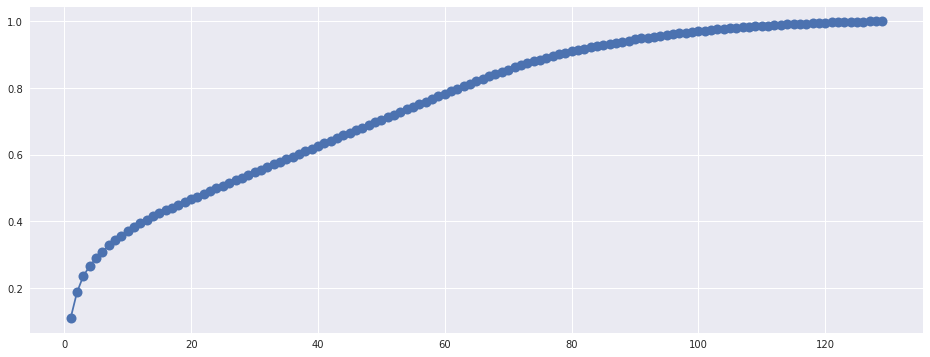

In [77]:
# Investigate the variance accounted for by each principal component.
v_results = pca_results(pca_azdias, azdiasDataset.columns.values)
v_display = v_results['Cumulated Variance'].copy().reset_index()
fig, ax = plt.subplots(figsize = (16, 6))
plt.plot( v_display.index.values + 1, 
          v_display['Cumulated Variance'], 
          marker = 'o', markersize = 10 )
plt.grid(True)
plt.show()

We reapply the PCA while selecting a wanted cumulated explained variance of 90%.

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_azdias = PCA(0.9)
X_pca_azdias = pca_azdias.fit_transform(azdiasFeatures)
g_PCAComponentsNo = pca_azdias.components_.shape[0]

v_results = pca_results(pca_azdias, azdiasDataset.columns.values)
print(f"Number of components: {g_PCAComponentsNo}")
print(f"Cumulated Variance:   {round(v_results.loc[v_results.index[len(v_results.index) - 1], 'Cumulated Variance'], 2)}")

Number of components: 78
Cumulated Variance:   0.9


### Discussion 2.2: Perform Dimensionality Reduction

The first step we did was to apply the PCA to the complete subDataset without specifing a number of components.

We have displayed the variances accounted by the different number of components and check the increase in the total explained variance.

We have retained 78 components out of 129 as the total explained variance is 90.00%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

-------

We define a function that will display the magnitude and direction of the coefficients for the original variables in a given component based on the results we have calculated earlier.

In [79]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def getCompWeight(p_results, p_comp):
    v_df = pd.DataFrame(p_results.loc[p_results.index[p_comp - 1]])
    v_df['weight'] = v_df[v_df.columns.values[0]].apply(np.abs)  
    v_df.loc['Component Variance', 'weight'] = 1
    v_df.loc['Cumulated Variance', 'weight'] = 1
    return pd.DataFrame(v_df.sort_values('weight', ascending = False)[v_df.columns.values[0]])

In [80]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(getCompWeight(v_results, 1).head(12))

Dimension 1
Cumulated Variance                0.1101
Component Variance                0.1101
MOBI_REGIO                       -0.2160
LP_STATUS_FEIN                   -0.2085
KBA05_ANTG1                      -0.2031
PLZ8_ANTG3                        0.1983
PLZ8_ANTG1                       -0.1979
LP_LEBENSPHASE_FEIN_Earners      -0.1935
KBA05_GBZ                        -0.1931
PLZ8_ANTG4                        0.1928
CAMEO_DEUG_2015                   0.1916
FINANZ_MINIMALIST                -0.1894

In [81]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(getCompWeight(v_results, 2).head(12))

Dimension 2
Cumulated Variance                 0.1871
Component Variance                 0.0770
PRAEGENDE_JUGENDJAHRE_Decade      -0.2579
ALTERSKATEGORIE_GROB               0.2522
FINANZ_SPARER                     -0.2437
SEMIO_REL                         -0.2346
FINANZ_VORSORGER                   0.2341
FINANZ_UNAUFFAELLIGER             -0.2295
SEMIO_PFLICHT                     -0.2215
SEMIO_TRADV                       -0.2205
FINANZ_ANLEGER                    -0.2111
GEBURTSJAHR                       -0.2103

In [82]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(getCompWeight(v_results, 3).head(12))

Dimension 3
Cumulated Variance       0.2364
Component Variance       0.0493
ANREDE_KZ               -0.3670
SEMIO_KAEM              -0.3393
SEMIO_VERT               0.3390
SEMIO_DOM               -0.3116
SEMIO_KRIT              -0.2801
SEMIO_FAM                0.2679
SEMIO_SOZ                0.2655
SEMIO_KULT               0.2595
SEMIO_ERL               -0.2043
SEMIO_RAT               -0.1822

We create a visualisation that will give us the complete image for the importance given to every original variable in the first 3 most important components. 

We have 2 heatmaps that are included in the visualisation. The one in the left displays the features that have a positive direction inside the given component and the one on the right displays the features that have a negative direction inside the given component. 

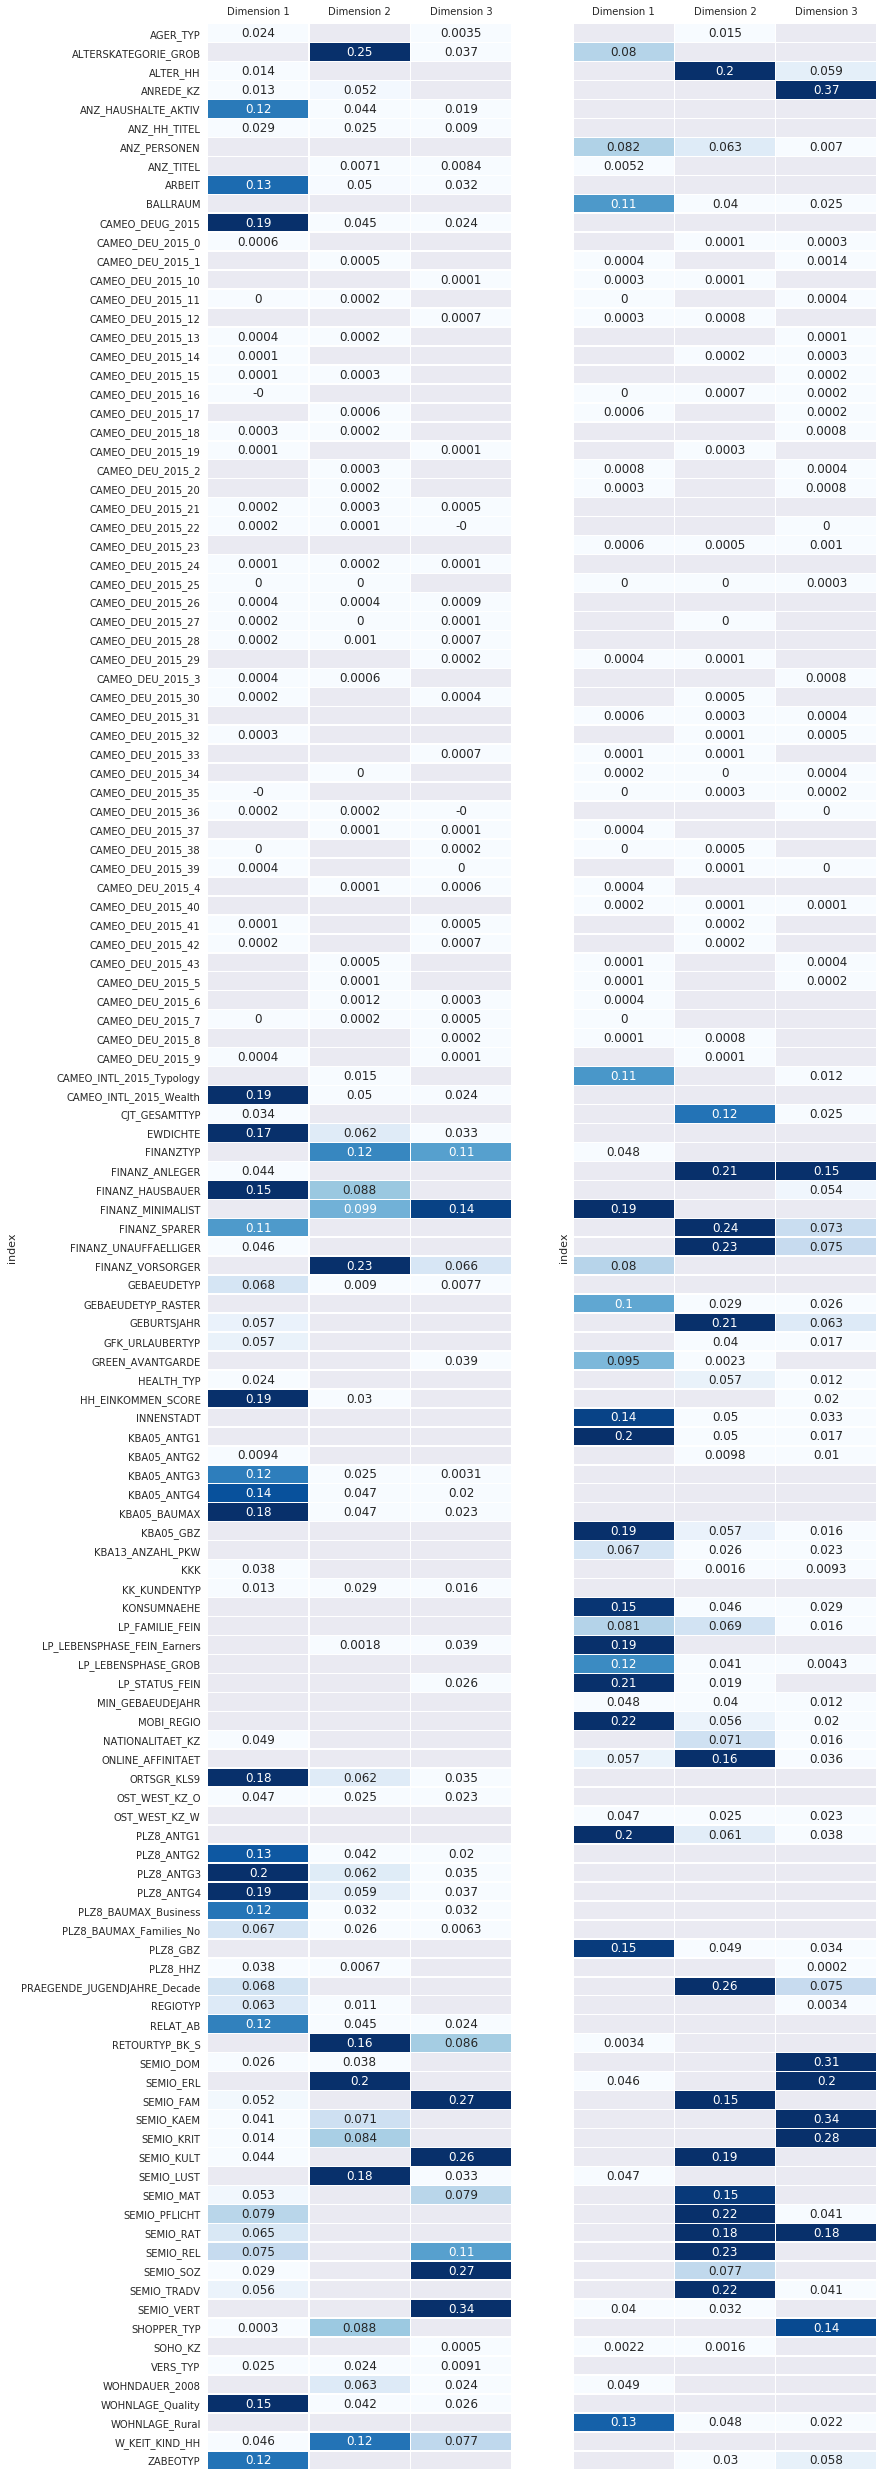

In [83]:
v_display = ( v_results.iloc[:3]
                       .drop(['Component Variance', 'Cumulated Variance'], axis = 1)
                       .T
                       .reset_index()
                       .sort_values('index', ascending = True) 
                       .set_index('index') ) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 45))
mask = np.zeros(v_display.shape)
mask[v_display < 0] = 1
sns.heatmap( v_display, annot = True, cmap = "Blues", vmin = 0.05, vmax = 0.15, 
             linewidths=.5, ax = ax1, robust = True, cbar = False, mask = mask )

mask = np.zeros(v_display.shape)
mask[v_display > 0] = 1
sns.heatmap( v_display.apply(np.abs), annot = True, cmap = "Blues", vmin = 0.05, vmax = 0.15, 
             linewidths=.5, ax = ax2, robust=True, cbar = False, mask = mask )
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax2.set_yticks([])
plt.show()

### Discussion 2.3: Interpret Principal Components

From the visualisation above we can see that the first 3 components explain a total variance of 23.64%.

----------

To interpret each principal components, we have to examine the magnitude and direction of the coefficients for the original variables. The larger the absolute value of the coefficient, the more important the corresponding variable is in calculating the component.

### First Principal Component Analysis - PCA1

The total variance explained by the first component is **11.01%**.

The first principal component **increases** with increasing:
   - PLZ8_ANTG3 - 0.1983 (Number of 6-10 family houses in the PLZ8 region)
   - PLZ8_ANTG4 - 0.1928 (Number of 10+ family houses in the PLZ8 region)
   - CAMEO_DEUG_2015 - 0.1916 (German CAMEO: Wealth / Life Stage Typology) 

The first principal component **decreases** with increasing:
   - MOBI_REGIO - -0.2160 (Movement patterns)
   - LP_STATUS_FEIN - -0.2085 (Social status, fine scale)
   - KBA05_ANTG1 - -0.2031 (Number of 1-2 family houses in the microcell)
   - PLZ8_ANTG1 - -0.1979 (Number of 1-2 family houses in the PLZ8 region)
   - LP_LEBENSPHASE_FEIN_Earners - -0.1935 (Life stage, fine scale - earners)
   - KBA05_GBZ - -0.1931 (Number of buildings in the microcell)
   - FINANZ_MINIMALIST - -0.1894 (Financial typology: MINIMALIST: low financial interest)

This component can be viewed as a measure of **high share of 6-10 family homes** for **urban working class**, for **single low-income earners of younger age** with **very high movement**, having no 1-2 family homes and with a **low financial interest**.


### Second Principal Component Analysis - PCA2

The total variance explained by the second component is **7.70%**.

The second principal component **increases** with increasing:
   - ALTERSKATEGORIE_GROB - 0.2522 (Estimated age based on given name analysis)
   - FINANZ_VORSORGER - 0.2341 (Financial typology: VORSORGER: be prepared)

The second principal component **decreases** with increasing:
   - PRAEGENDE_JUGENDJAHRE_Decade - -0.2579 (Decade for the dominating movement of person's youth)
   - FINANZ_SPARER - -0.2437 (Financial typology: SPARER: money-saver)
   - SEMIO_REL - -0.2346 (Personality typology: religious)
   - FINANZ_UNAUFFAELLIGER - -0.2295 (Financial typology: UNAUFFAELLIGER: inconspicuous)
   - SEMIO_PFLICHT - -0.2215 (Personality typology: PFLICHT: dutiful)
   - SEMIO_TRADV - -0.2205 (Personality typology: TRADV: tradional-minded)
   - FINANZ_ANLEGER - -0.2111 (Financial typology: ANLEGER: investor)
   - GEBURTSJAHR - -0.2103 (Year of birth)

This component can be viewed as a measure of people **over 60 years old**, with a very **high interest** in money-saving, investing and inconspicuous and a **low interest** in just being financially prepared. For the personality typology, they have the **highest affinity** to religion, being dutiful and tradional-minded.


### Third Principal Component Analysis - PCA3

The total variance explained by the third component is **4.93%**.

The third principal component **increases** with increasing:
   - SEMIO_VERT - 0.3390 (Personality typology: VERT: dreamful)
   - SEMIO_FAM - 0.2679 (Personality typology: FAM: family-minded)
   - SEMIO_SOZ - 0.2655 (Personality typology: SOZ: socially-minded)
   - SEMIO_KULT - 0.2595 (Personality typology: KULT: cultural-minded)
   
The third principal component **decreases** with increasing:
   - ANREDE_KZ - -0.3670 (Gender)
   - SEMIO_KAEM - -0.3393 (Personality typology: KAEM: combative attitude)
   - SEMIO_DOM - -0.3116 (Personality typology: DOM: dominant-minded)
   - SEMIO_KRIT - -0.2801 (Personality typology: KRIT: critical-minded)
   - SEMIO_ERL - -0.2043 (Personality typology: ERL: event-oriented)
   - SEMIO_RAT - -0.1822 (Personality typology: RAT: rational)

This component can be viewed as a measure of **male** people having a personality typology with the **highest affinity** to combative attitude, dominant-minded, critical-minded, event-oriented and rational. Their personality typology has the **lowest affinity** to be dreamful, have a family and be socially or cultural minded.  



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [84]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def fitClusters(p_X, p_from, p_to):
    kMeansVar = {}
    for key in range(p_from, p_to):
        kMeansVar[key] = KMeans( random_state = g_random_state,
                                 n_clusters = key, 
                                 precompute_distances = True,
                                 n_jobs = -1,
                                 n_init = 15,
                                 tol = 1e-3 ).fit(p_X)
        print(f'For {key} cluster(s) the sum of distances to the cluster center is {round(kMeansVar[key].inertia_, 2)}.')        
    return kMeansVar

kMeansVar = fitClusters(X_pca_azdias, 1, 14)

For 1 cluster(s) the sum of distances to the cluster center is 92817607.97.
For 2 cluster(s) the sum of distances to the cluster center is 84176482.96.
For 3 cluster(s) the sum of distances to the cluster center is 80473409.52.
For 4 cluster(s) the sum of distances to the cluster center is 77964159.53.
For 5 cluster(s) the sum of distances to the cluster center is 76531860.54.
For 6 cluster(s) the sum of distances to the cluster center is 75231282.87.
For 7 cluster(s) the sum of distances to the cluster center is 74114501.42.
For 8 cluster(s) the sum of distances to the cluster center is 73123363.0.
For 9 cluster(s) the sum of distances to the cluster center is 72465401.86.
For 10 cluster(s) the sum of distances to the cluster center is 71811528.71.
For 11 cluster(s) the sum of distances to the cluster center is 71142525.44.
For 12 cluster(s) the sum of distances to the cluster center is 70503726.38.
For 13 cluster(s) the sum of distances to the cluster center is 70205527.84.


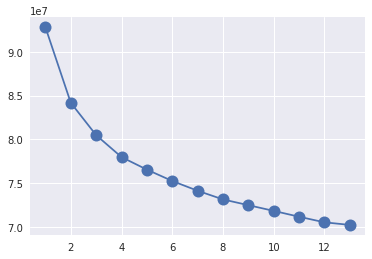

In [85]:
plt.plot( kMeansVar.keys(), 
          [kMeansVar[key].inertia_ for key in kMeansVar.keys()], 
          marker = 'o', markersize = 12 )
plt.show()

We create a function for the elbow method based on the calculation of the distances within the cluster.

[0.0,
 0.085912228041281277,
 0.93970756491264285,
 0.98356118662597525,
 0.98596103005085478,
 0.99783913868225127,
 0.99752179005404829,
 0.99812233411508511,
 0.9946240614100692,
 0.99523134452939399,
 0.99417868309216828,
 0.99882437337892593,
 0.10000000000000001]

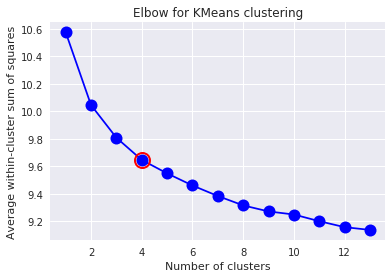

In [87]:
def elbowMethod(p_X, p_kMeansVar):
    v_Key = list(p_kMeansVar.keys())
    centroids = [p_kMeansVar[key].cluster_centers_ for key in p_kMeansVar.keys()]
    D_k = [cdist(p_X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D, axis = 1) for D in D_k]
    dist = [np.min(D, axis = 1) for D in D_k]
    avgWithinSS = [sum(d) / p_X.shape[0] for d in dist]

    seg_threshold = 0.98

    #The angle between points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] 
                  + [ segments_gain(*[np.array([v_Key[j], criterion[j]]) for j in range(i - 1, i + 2)]) 
                         for i in range(len(v_Key) - 2) ] + [0.1, ])

    display(list(seg_gains))

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot( v_Key, avgWithinSS, 'b*-', marker = 'o', markersize = 12 )
    ax.plot( v_Key[kIdx], 
             avgWithinSS[kIdx], 
             marker = 'o', 
             markersize = 15, 
             markeredgewidth = 2, 
             markeredgecolor = 'r', 
             markerfacecolor = 'None' )
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    return
    
elbowMethod(X_pca_azdias, kMeansVar)

We create a function that calculates the silhouette score. As we cannot calculate the score for all the dataset, I have decided to split it based on the following logic: 
  - get the clusters number in parameter
  - predict the labels and get the centroids
  - calculate the distances between all the points and their centroid
  - sort the points based on the distance to their centroid
  - select every "i" sample based on a "gap" given as parameter

In [88]:
def getTestValues(p_X, p_kMeansVar, p_n_clusters, p_gapNo, p_computeSilhouette = False):
    labels    = p_kMeansVar[p_n_clusters].predict(p_X)
    centroids = p_kMeansVar[p_n_clusters].cluster_centers_
    
    v_data = np.array([0 for i in range(p_X.shape[1])])
    v_labels = np.array([0])
    for n_cluster in range(p_n_clusters):
        v_x = p_X[labels == n_cluster]    
        v_centroid = centroids[n_cluster].reshape(1, -1)
        
        v_x = np.append(v_x, cdist(v_x, v_centroid, 'euclidean'), axis = 1)
        v_x = v_x[v_x[:, -1].argsort()] # Sort by the distances to the centroid
        v_x = v_x[1::p_gapNo, :] # Select every ith element
        v_x = v_x[:, :-1]
        
        v_label = np.full((v_x.shape[0], 1), n_cluster)
        
        v_data = np.vstack((v_data, v_x))
        v_labels = np.vstack((v_labels, v_label))
    
    if p_computeSilhouette:
        v_silhouette = silhouette_score(v_data, v_labels.ravel(), metric = 'euclidean')
        v_sample_silhouette_values = silhouette_samples(v_data, v_labels.ravel())
        
        return v_silhouette, \
               v_sample_silhouette_values.reshape(v_sample_silhouette_values.shape[0], 1), \
               v_data, \
               v_labels
        
    return None, None, v_data, v_labels

We calculate the silhouette score for different numbers of clusters.

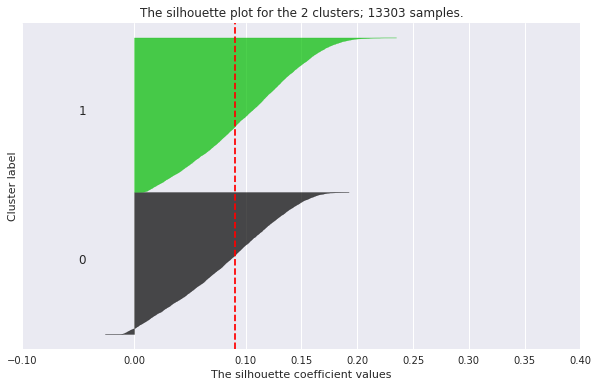

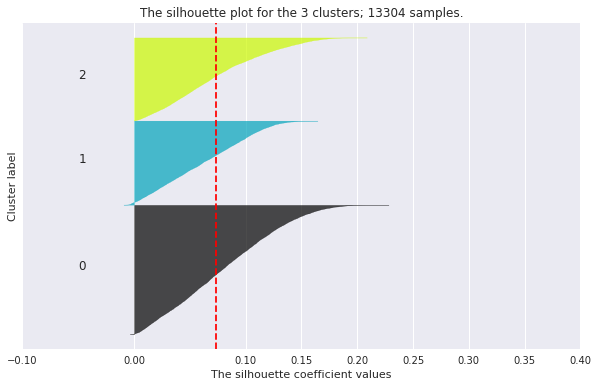

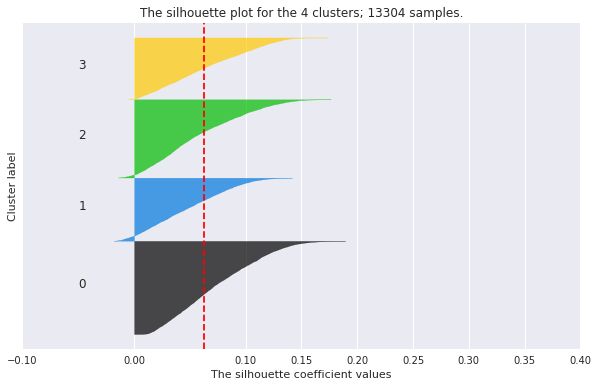

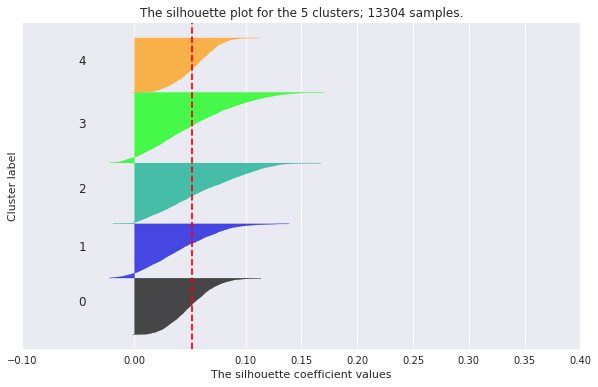

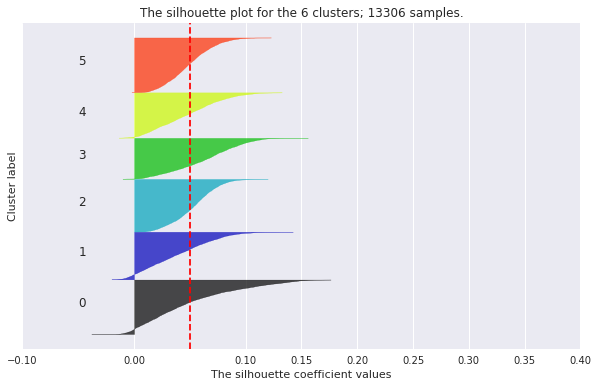

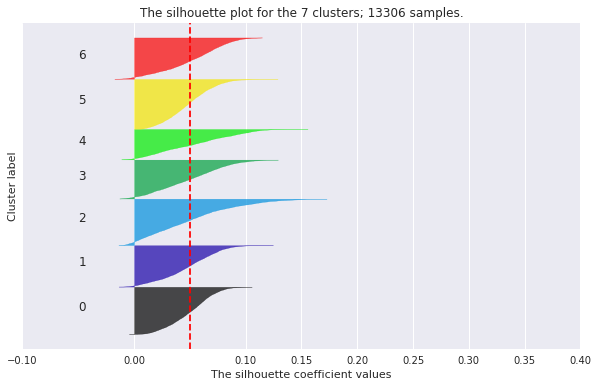

In [89]:
for n_clusters in list(kMeansVar.keys())[1:7]:
    v_silhouette, v_sample_silhouette_values, v_data, v_labels = getTestValues(X_pca_azdias, kMeansVar, n_clusters, 60, True)    
    
    fig, ax = plt.subplots(figsize = (10, 6))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = v_sample_silhouette_values[v_labels == i]
        ith_cluster_silhouette_values.sort()        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
            
        color = plt.cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx( np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7 )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title(f"The silhouette plot for the {n_clusters} clusters; {v_labels.shape[0]} samples.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x = v_silhouette, color="red", linestyle="--")    
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
    plt.show()

In [90]:
g_clusterNo = 4

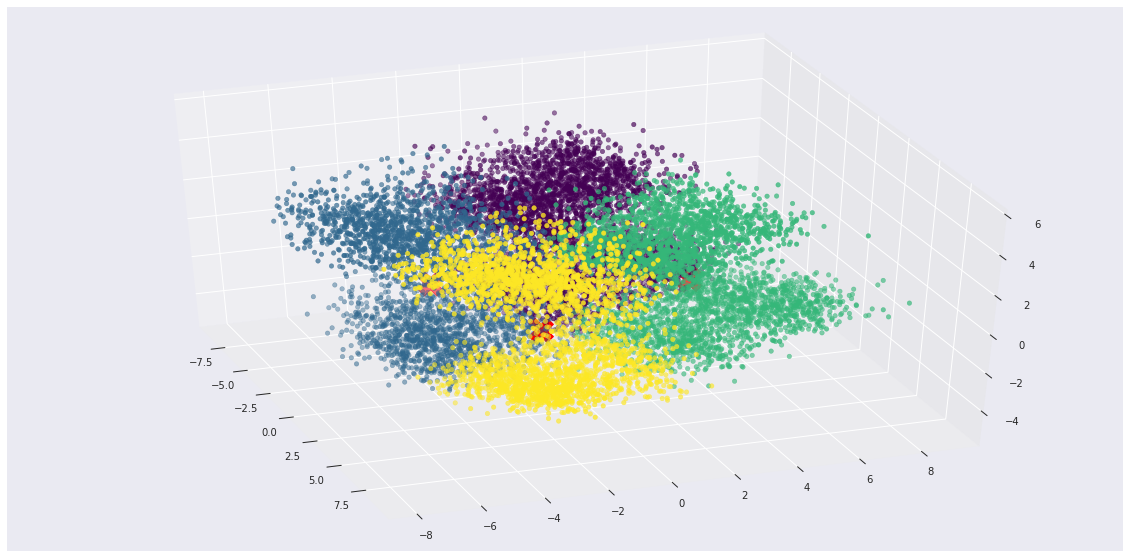

In [91]:
kmean = kMeansVar[g_clusterNo]
centroids = kmean.cluster_centers_

v_silhouette, v_sample_silhouette_values, v_data, v_labels = getTestValues(X_pca_azdias, kMeansVar, g_clusterNo, 60, False) 

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d', elev = 40, azim = -20)
ax.scatter( v_data[:, 0:1], 
            v_data[:, 1:2], 
            v_data[:, 2:3], 
            c = v_labels.ravel(), cmap = 'viridis', linewidth = 0.5 )
ax.scatter( centroids[:, 0:1], 
            centroids[:, 1:2], 
            centroids[:, 2:3], 
            s = 600, marker = 'X', color = 'r', linewidth = 1 )
plt.show()

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean = kMeansVar[g_clusterNo]
azdiasLabels = kmean.fit_predict(X_pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

Based on the KMean models tested and the value returned for the inertia and the Elbow method I have decided to keep **4 clusters**.

The Silhouette score is quite low (a value of 0 indicates that the sample is at the boundary of the distance between the two cluster), but this could be explained by the fact that we cannot fit into memory the calculation of all the distances for the complete dataset, so we have chosen to take samples at a given interval. These samples were calculated based on the distance to the certer of the cluster.

When we visualize the cluster based on the first 3 pricipal components we can see that they are not completely well defined, but this can be explained by the fact that the first 3 components can only explain 23.64% of the complete variance in the dataset.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [94]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customersClean, _ = clean_data( p_df = customers, 
                                p_splitMixedDict = { 'PRAEGENDE_JUGENDJAHRE': ['Stream', 'Decade'],
                                                     'CAMEO_INTL_2015': ['Wealth', 'Typology'],
                                                     'PLZ8_BAUMAX': ['Business', 'Families_No'],
                                                     'LP_LEBENSPHASE_FEIN': ['Earners', 'Status'],
                                                     'WOHNLAGE': ['Rural', 'Quality'] },
                                p_splitMixedFunc = split_Column,
                                p_debug = False )

['TITEL_KZ',
 'LP_LEBENSPHASE_FEIN_Status',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'PRAEGENDE_JUGENDJAHRE_Stream']

Initial values to encode for column CAMEO_DEU_2015: ['1A' '5D' '4C' ..., '4D' '4C' '5C']


In [99]:
customersDataset = customersClean.copy()
customersFeatures = imputer.transform(customersDataset)
customersFeatures = scaler.transform(customersFeatures)

In [100]:
# Apply PCA to the data
pca_cust = PCA(g_PCAComponentsNo)
X_pca_customers = pca_cust.fit_transform(customersFeatures)

In [101]:
# Obtaining cluster predictions
customersLabels = kmean.predict(X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
print(f'Number of observations: general population {azdiasLabels.shape[0]}; customers {customersLabels.shape[0]}.')

v_distribution = []
for ith_cluster in range(g_clusterNo):
    ith_lbl_azdias = azdiasLabels[azdiasLabels == ith_cluster]
    ith_lbl_cust = customersLabels[customersLabels == ith_cluster]
    
    ith_lbl_azdias_per = round(ith_lbl_azdias.shape[0] / azdiasLabels.shape[0] * 100, 2)
    ith_lbl_cust_per = round(ith_lbl_cust.shape[0] / customersLabels.shape[0] * 100, 2)
    
    v_distribution.append((ith_cluster + 1, ith_lbl_azdias_per, ith_lbl_cust_per))
    
    print(f'Proportion of data for cluster {ith_cluster + 1}: general population {round(ith_lbl_azdias_per, 2)} ({ith_lbl_azdias.shape[0]}); customers {round(ith_lbl_cust_per, 2)} ({ith_lbl_cust.shape[0]}).')

Number of observations: general population 798054; customers 141726.
Proportion of data for cluster 1: general population 31.44 (250887); customers 37.2 (52723).
Proportion of data for cluster 2: general population 26.45 (211071); customers 19.72 (27945).
Proportion of data for cluster 3: general population 21.29 (169930); customers 24.04 (34072).
Proportion of data for cluster 4: general population 20.82 (166166); customers 19.04 (26986).


In [106]:
def displayProfiles( p_cluster, 
                     p_columns, 
                     p_cust_labels, 
                     p_cust_PCA, 
                     p_cust_X_pca,
                     p_cust_index, 
                     p_azdias_labels, 
                     p_azdias_PCA, 
                     p_azdias_X_pca,
                     p_azdias_index ):
    
    v_cust = p_cust_PCA.inverse_transform(p_cust_X_pca)    
    v_cust = np.round(scaler.inverse_transform(v_cust))    
    v_cust = pd.DataFrame(v_cust, columns = p_columns, index = p_cust_index)
    v_cust = v_cust.iloc[np.where(p_cust_labels == (p_cluster - 1 ))].copy()
    print(f'Customers: {v_cust.shape}')
    
    v_azdias = p_azdias_PCA.inverse_transform(p_azdias_X_pca)    
    v_azdias = np.round(scaler.inverse_transform(v_azdias))    
    v_azdias = pd.DataFrame(v_azdias, columns = p_columns, index = p_azdias_index)
    v_azdias = v_azdias.iloc[np.where(p_azdias_labels == (p_cluster - 1 ))].copy()
    print(f'General population: {v_azdias.shape}')
    
    v_df = pd.DataFrame()
    for item in p_columns:
        v_values = pd.DataFrame({ 'Column Name':        item, 
                                  'Cust Values No':     v_cust[item].value_counts(), 
                                  'Azdias Values No':   v_azdias[item].value_counts() }).reset_index()
        v_values.columns = ['Values', 'Azdias Values', 'Column Name', 'Cust Values']
        v_values = v_values[['Column Name', 'Values', 'Azdias Values', 'Cust Values' ]]
        v_values['Azdias Values'] = v_values['Azdias Values'] / v_azdias.shape[0]
        v_values['Cust Values'] = v_values['Cust Values'] / v_cust.shape[0]
        v_df = v_df.append(v_values, ignore_index = True)  
        
    v_df.set_index('Column Name', inplace = True)
    v_df.drop([item for item in v_df.index.values if 'CAMEO_DEU_2015' in item], inplace = True)
    v_df.reset_index(inplace = True)
    v_df = v_df.fillna(0)
    
    v_df['Diff'] = (v_df['Azdias Values'] - v_df['Cust Values']).apply(np.abs)
    
    v_df = v_df.sort_values(['Diff', 'Column Name', 'Values'], ascending = [False, True, True])
    
    v_df = v_df[ ( v_df['Azdias Values'] > 0.6 )
                 | ( v_df['Cust Values'] > 0.6 )
                 | ( v_df['Diff'] > 0.3 ) ]
            
    v_df.set_index(['Column Name', 'Values'], inplace = True)
    
    f, ax = plt.subplots(figsize=(6, round(v_df.shape[0] / 3)))
    sns.heatmap( v_df, annot = True, fmt = ".0%", 
                 cmap = "Blues", vmin = 0.30, vmax = 1.00, linewidths = .5, ax = ax )
    ax.xaxis.tick_top()
    plt.show()
    
    return

We calculate the profile of customers and general population in four situations:
    - for a cluster that is overrepresented in the customer data compared to the general population
    - for a cluster that is underrepresented in the customer data compared to the general population
    - for a cluster that has the same representation in the customer data compared to the general population
    - for a separate cluster which includes the features that had more than 34 missing values per row

#### Calculate the profile of customers and general population for a cluster that is overrepresented in the customer data compared to the general population

Selected cluster: 1. General population: 31.44; Customers 37.2.
Customers: (52723, 129)
General population: (250887, 129)


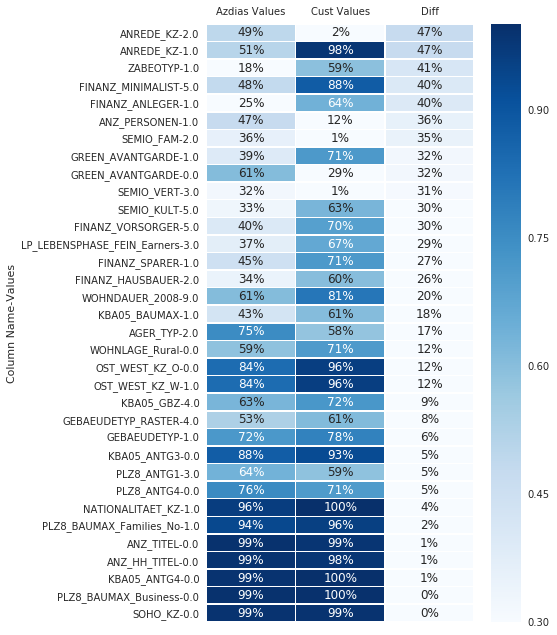

In [107]:
for idx in range(len(v_distribution)):
    if v_distribution[idx][2] > v_distribution[idx][1] + 5:        
        v_idx = idx
        v_cluster = v_distribution[idx][0]
        break
print(f'Selected cluster: {v_cluster}. General population: {v_distribution[v_idx][1]}; Customers {v_distribution[v_idx][2]}.')
displayProfiles( p_cluster = v_cluster, 
                 p_columns = customersDataset.columns, 
                 p_cust_labels = customersLabels, 
                 p_cust_PCA = pca_cust, 
                 p_cust_X_pca = X_pca_customers,
                 p_cust_index = customersDataset.index, 
                 p_azdias_labels = azdiasLabels, 
                 p_azdias_PCA = pca_azdias, 
                 p_azdias_X_pca = X_pca_azdias,
                 p_azdias_index = azdiasDataset.index )

#### Calculate the profile of customers and general population for a cluster that is underrepresented in the customer data compared to the general population

Selected cluster: 2. General population: 26.45; Customers 19.72.
Customers: (27945, 129)
General population: (211071, 129)


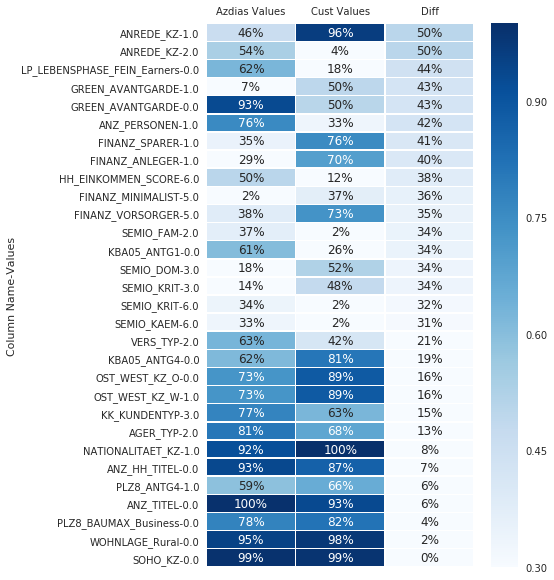

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
for idx in range(len(v_distribution)):
    if v_distribution[idx][1] > v_distribution[idx][2] + 5:         
        v_idx = idx      
        v_cluster = v_distribution[idx][0]
        break
print(f'Selected cluster: {v_cluster}. General population: {v_distribution[v_idx][1]}; Customers {v_distribution[v_idx][2]}.')
displayProfiles( p_cluster = v_cluster, 
                 p_columns = customersDataset.columns, 
                 p_cust_labels = customersLabels, 
                 p_cust_PCA = pca_cust, 
                 p_cust_X_pca = X_pca_customers,
                 p_cust_index = customersDataset.index, 
                 p_azdias_labels = azdiasLabels, 
                 p_azdias_PCA = pca_azdias, 
                 p_azdias_X_pca = X_pca_azdias,
                 p_azdias_index = azdiasDataset.index )

#### Calculate the profile of customers and general population for a cluster that has the same representation in the customer data compared to the general population

Selected cluster: 3. General population: 21.29; Customers 24.04.
Customers: (34072, 129)
General population: (169930, 129)


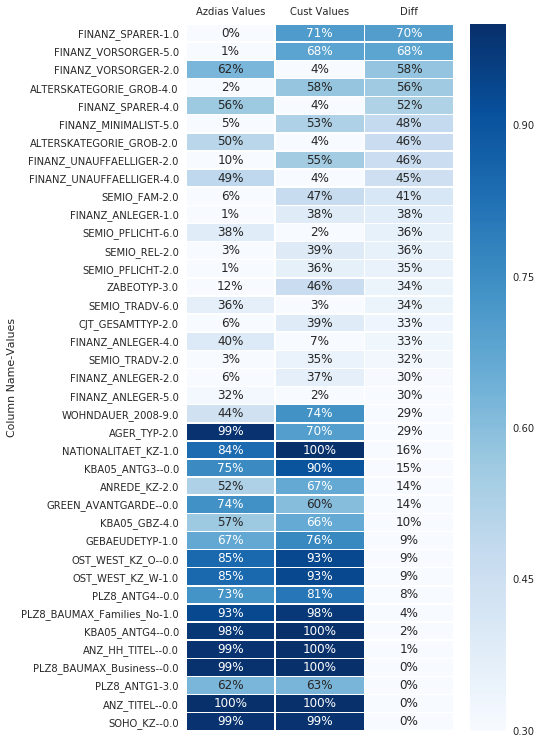

In [110]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
for idx in range(len(v_distribution)):
    if np.abs(v_distribution[idx][1] - v_distribution[idx][2]) < 5:         
        v_idx = idx      
        v_cluster = v_distribution[idx][0]
        break
print(f'Selected cluster: {v_cluster}. General population: {v_distribution[v_idx][1]}; Customers {v_distribution[v_idx][2]}.')
displayProfiles( p_cluster = v_cluster, 
                 p_columns = customersDataset.columns, 
                 p_cust_labels = customersLabels, 
                 p_cust_PCA = pca_cust, 
                 p_cust_X_pca = X_pca_customers,
                 p_cust_index = customersDataset.index, 
                 p_azdias_labels = azdiasLabels, 
                 p_azdias_PCA = pca_azdias, 
                 p_azdias_X_pca = X_pca_azdias,
                 p_azdias_index = azdiasDataset.index )


#### Calculate the profile of customers and general population for a separate cluster which includes the features that had more than 34 missing values per row
We consider the dataset that we left out earlies as a new cluster, so we will try to define the profile of the general population and customers that we fit into it.

In [111]:
def getClusterProfile(p_df):
    v_rows = p_df.isnull().astype('int')
    v_rows_1 = v_rows[v_rows.sum(axis = 1) >= g_rowsThreshold].copy()
    
    v_rowCorr = pd.DataFrame({ f'More than {g_rowsThreshold} %': v_rows_1.sum() / v_rows_1.shape[0] * 100 })
    v_columns = v_rowCorr[v_rowCorr[f'More than {g_rowsThreshold} %'] < 60]

    v_exclude = p_df[v_columns.index.values].iloc[v_rows_1.index].copy()
    v_exclude.reset_index(drop = True, inplace = True)
    
    v_exclude, _ = clean_data( p_df = v_exclude, 
                               p_splitMixedDict = {},
                               p_splitMixedFunc = split_Column,
                               p_debug = False )
    
    v_dataset = imputer.fit_transform(v_exclude)
    v_dataset = scaler.fit_transform(v_dataset)
            
    return v_dataset, v_exclude.columns.values

def display3PCA():
    v_df = ( getCompWeight(v_results, 1).head(12).reset_index()
               .merge(getCompWeight(v_results, 2).head(12).reset_index(), left_index = True, right_index = True)
               .merge(getCompWeight(v_results, 3).head(12).reset_index(), left_index = True, right_index = True) )
    v_df.columns = [ 'Dimension 1 - col', 'Dimension 1',
                     'Dimension 2 - col', 'Dimension 2',
                     'Dimension 3 - col', 'Dimension 3' ]
    display(v_df)

['TITEL_KZ',
 'LP_LEBENSPHASE_FEIN_Status',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'PRAEGENDE_JUGENDJAHRE_Stream']

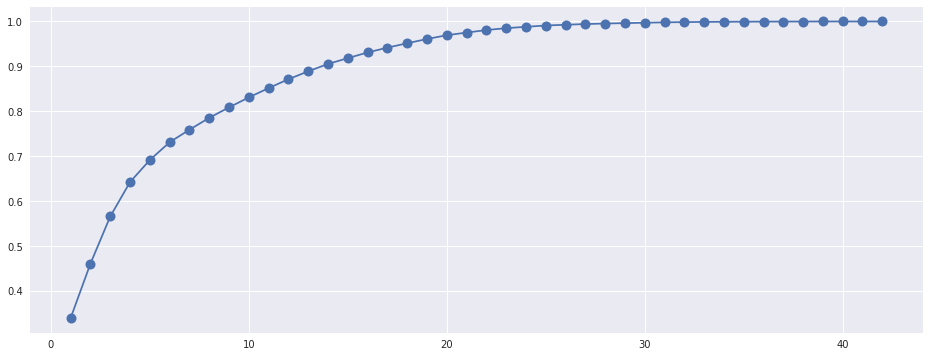

Dimension 1 - col  Dimension 1    Dimension 2 - col  Dimension 2  \
0      Cumulated Variance       0.3396   Cumulated Variance       0.4606   
1      Component Variance       0.3396   Component Variance       0.1210   
2              SEMIO_VERT       0.2655           SEMIO_KULT       0.3997   
3       FINANZ_MINIMALIST       0.2639            SEMIO_MAT       0.3694   
4           FINANZ_SPARER      -0.2591            SEMIO_FAM       0.3637   
5          FINANZ_ANLEGER      -0.2587            SEMIO_ERL      -0.3177   
6           SEMIO_PFLICHT      -0.2570            SEMIO_DOM      -0.2135   
7   FINANZ_UNAUFFAELLIGER      -0.2545           SEMIO_KAEM      -0.2017   
8               SEMIO_REL      -0.2512          SEMIO_TRADV       0.1974   
9        FINANZ_VORSORGER       0.2484           SEMIO_KRIT      -0.1928   
10              SEMIO_DOM      -0.2329             AGER_TYP       0.1734   
11             SEMIO_KRIT      -0.2291  LP_LEBENSPHASE_FEIN       0.1685   

        Dimension 3 - col  Dimension 3  
0      Cumulated Variance       0.5656  
1      Component Variance       0.1050  
2               SEMIO_RAT       0.3554  
3              HEALTH_TYP       0.3426  
4              SEMIO_LUST      -0.3307  
5             SEMIO_TRADV       0.3277  
6                ZABEOTYP       0.2926  
7             SHOPPER_TYP      -0.2752  
8   PRAEGENDE_JUGENDJAHRE       0.2417  
9             GEBURTSJAHR       0.2408  
10               AGER_TYP       0.2331  
11               VERS_TYP       0.2041

In [112]:
v_cust, v_columns = getClusterProfile(customers)

pca = PCA()
X_pca = pca.fit_transform(v_cust)

v_results = pca_results(pca, v_columns)
v_display = v_results['Cumulated Variance'].copy().reset_index()
fig, ax = plt.subplots(figsize = (16, 6))
plt.plot( v_display.index.values + 1, 
          v_display['Cumulated Variance'], 
          marker = 'o', markersize = 10 )
plt.grid(True)
plt.show()

display3PCA()

['TITEL_KZ',
 'LP_LEBENSPHASE_FEIN_Status',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'PRAEGENDE_JUGENDJAHRE_Stream']

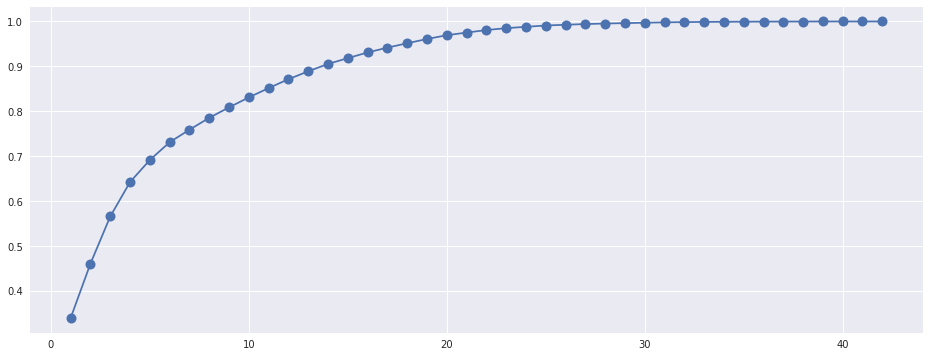

Dimension 1 - col  Dimension 1    Dimension 2 - col  Dimension 2  \
0      Cumulated Variance       0.3396   Cumulated Variance       0.4606   
1      Component Variance       0.3396   Component Variance       0.1210   
2              SEMIO_VERT       0.2655           SEMIO_KULT       0.3997   
3       FINANZ_MINIMALIST       0.2639            SEMIO_MAT       0.3694   
4           FINANZ_SPARER      -0.2591            SEMIO_FAM       0.3637   
5          FINANZ_ANLEGER      -0.2587            SEMIO_ERL      -0.3177   
6           SEMIO_PFLICHT      -0.2570            SEMIO_DOM      -0.2135   
7   FINANZ_UNAUFFAELLIGER      -0.2545           SEMIO_KAEM      -0.2017   
8               SEMIO_REL      -0.2512          SEMIO_TRADV       0.1974   
9        FINANZ_VORSORGER       0.2484           SEMIO_KRIT      -0.1928   
10              SEMIO_DOM      -0.2329             AGER_TYP       0.1734   
11             SEMIO_KRIT      -0.2291  LP_LEBENSPHASE_FEIN       0.1685   

        Dimension 3 - col  Dimension 3  
0      Cumulated Variance       0.5656  
1      Component Variance       0.1050  
2               SEMIO_RAT       0.3554  
3              HEALTH_TYP       0.3426  
4              SEMIO_LUST      -0.3307  
5             SEMIO_TRADV       0.3277  
6                ZABEOTYP       0.2926  
7             SHOPPER_TYP      -0.2752  
8   PRAEGENDE_JUGENDJAHRE       0.2417  
9             GEBURTSJAHR       0.2408  
10               AGER_TYP       0.2331  
11               VERS_TYP       0.2041

In [113]:
v_azdias, v_columns = getClusterProfile(azdias)

pca = PCA()
X_pca = pca.fit_transform(v_cust)

v_results = pca_results(pca, v_columns)
v_display = v_results['Cumulated Variance'].copy().reset_index()
fig, ax = plt.subplots(figsize = (16, 6))
plt.plot( v_display.index.values + 1, 
          v_display['Cumulated Variance'], 
          marker = 'o', markersize = 10 )
plt.grid(True)
plt.show()

display3PCA()

### Discussion 3.3: Compare Customer Data to Demographics Data

### Cluster overrepresented in the customer data

In the cluster that is overrepresented in the customer data compared to the general population we can see in the heatmap that we have mostly **families** from area without 10+ family homes, **mainly 1-2 family homes** from **residential areas** (sometimes rural area).


### Cluster underrepresented in the customer data

In the cluster that is underrepresented in the customer data compared to the general population we can see in the heatmap that we have either **companies** of **families from areas with a low share of 10+ family homes** mostly in the **city**.


### Cluster that has the same representation in the customer data and general population

In the cluster that has the same representation in the customer data compared to the general population we can see in the heatmap that we have mostly **families** from area without 10+ family homes, **mainly 1-2 family homes** from **residential areas** (sometimes rural area).


### Separate cluster for the features that had more than 34 missing values per row

We have also created a separate cluster for the features that had more than 34 missing values per row.

We can see that for this cluster, the profiles for the customers and the general population are almost the same.

We can see that 3 principal components are enough in order to explain 57% of the total variance for the dataset. These 3 different profiles correspond to the 3 different picks we have seen in the pattern of missing data.

----

The first principal component **increases** with increasing:
    - SEMIO_VERT (Personality typology: VERT: dreamful ==> lowest affinity)
    - FINANZ_MINIMALIST (Financial typology: low financial interest ==> very low)
    - FINANZ_VORSORGER (Financial typology: be prepared ==> very low)

The first principal component **decreases** with increasing:
    - FINANZ_SPARER (Financial typology: money-saver ==> very high)
    - FINANZ_ANLEGER (Financial typology: investor ==> very high)
    - SEMIO_PFLICHT (Personality typology: dutiful ==> highest affinity)
    - FINANZ_UNAUFFAELLIGER (Financial typology: inconspicuous ==> very high)
    - SEMIO_REL (Personality typology: religious ==> highest affinity)
    - SEMIO_DOM (Personality typology: dominant-minded ==> highest affinity)
    - SEMIO_KRIT (Personality typology: critical-minded ==> highest affinity)

----

The second principal component **increases** with increasing:
    - SEMIO_KULT (Personality typology: cultural-minded ==> lowest affinity)
    - SEMIO_MAT (Personality typology: materialistic ==> lowest affinity)
    - SEMIO_FAM (Personality typology: family-minded ==> lowest affinity)
    - SEMIO_TRADV (Personality typology: tradional-minded ==> lowest affinity)
    - AGER_TYP (Best-ager typology ==> experience-driven elderly)
    - LP_LEBENSPHASE_FEIN (Life stage, fine scale ==> top earners at retirement age from multiperson households)

The second principal component **decreases** with increasing:
    - SEMIO_ERL (Personality typology: event-oriented ==> highest affinity
    - SEMIO_DOM (Personality typology: dominant-minded ==> highest affinity
    - SEMIO_KAEM (Personality typology: combative attitude ==> highest affinity
    - SEMIO_KRIT (Personality typology: critical-minded ==> highest affinity

----

The third principal component **increases** with increasing:
    - SEMIO_RAT (Personality typology: rational ==> lowest affinity)
    - HEALTH_TYP (Health typology ==> jaunty hedonists)
    - SEMIO_TRADV (Personality typology: tradional-minded ==> lowest affinity)
    - ZABEOTYP (Energy consumption typology ==> indifferent)
    - PRAEGENDE_JUGENDJAHRE (Dominating movement of person's youth ==> 90s - digital media kids)
    - GEBURTSJAHR (Year of birth ==> young person)
    - AGER_TYP (Best-ager typology ==> experience-driven elderly)
    - VERS_TYP (Insurance typology ==> individualistic-accepting risks)

The third principal component **decreases** with increasing:
    - SEMIO_LUST (Personality typology: sensual-minded ==> lowest affinity)
    - SHOPPER_TYP (Shopper typology ==> external supplied hedonists)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.